Environment setup:
```
conda create -n earth2studio python=3.12 -y 
conda activate earth2studio
pip install uv
export UV_CACHE_DIR="/projectnb/eb-general/wade/uv_cache"
uv pip install "earth2studio @ git+https://github.com/NVIDIA/earth2studio.git@0.10.0"
uv pip install "earth2studio[fcn]"
uv pip install numpy matplotlib pandas xarray cartopy cmocean tqdm
uv pip install "makani @ git+https://github.com/NVIDIA/modulus-makani.git@28f38e3e929ed1303476518552c64673bbd6f722"
uv pip install earth2studio[sfno]
```


In [2]:
# print versions of makani and earth2studio
import earth2studio
print(f"earth2studio version: {earth2studio.__version__}")
import makani
print(f"makani version: {makani.__version__}")


earth2studio version: 0.10.0rc0
makani version: 0.2.0


# Running inference with SFNO checkpoints

In [1]:
import os
import subprocess
from dotenv import load_dotenv

from earth2studio.io import ZarrBackend
from deterministic_update import deterministic
from SFNO_update import SFNO

import earth2studio.data as data
from earth2studio.models.auto import Package
from utils import create_initialization_file #filename_to_year, datetime_range, open_hdf5 # these aren't used in this script currently

from datetime import datetime, timedelta
import json
import xarray as xr
from typing import List
import shutil
import sys
import gc
import numpy as np
import time

import torch

/projectnb/eb-general/wade/.conda/envs/earth2studio/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/projectnb/eb-general/wade/.conda/envs/earth2studio/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Should be using earth2studio version 0.10.0 and makani version 0.2.0.

In [2]:
# Check if CUDA (GPU support) is available
is_available = torch.cuda.is_available()
print(f"Is CUDA available? {is_available}")

if is_available:
    # Get the number of available GPUs
    gpu_count = torch.cuda.device_count()
    print(f"Number of GPUs available: {gpu_count}")

    # Get the ID of the current GPU
    current_gpu = torch.cuda.current_device()
    print(f"Current GPU ID: {current_gpu}")

    # Get the name of the current GPU
    gpu_name = torch.cuda.get_device_name(current_gpu)
    print(f"Current GPU Name: {gpu_name}")

    print(f"Memory (VRAM):      {torch.cuda.get_device_properties(current_gpu).total_memory / 1e9:.2f} GB")
else:
    print("CUDA is not available. Running on CPU.")

Is CUDA available? True
Number of GPUs available: 1
Current GPU ID: 0
Current GPU Name: NVIDIA H200 NVL
Memory (VRAM):      150.11 GB


In [ ]:
import os
import subprocess
from dotenv import load_dotenv

from earth2studio.io import ZarrBackend
from deterministic_update import deterministic
from SFNO_update import SFNO

import earth2studio.data as data
from earth2studio.models.auto import Package
from utils import create_initialization_file #filename_to_year, datetime_range, open_hdf5 # these aren't used in this script currently

from datetime import datetime, timedelta
import json
import xarray as xr
from typing import List
import shutil
import sys
import gc
import numpy as np
import time

import torch

# Check if CUDA (GPU support) is available
is_available = torch.cuda.is_available()
print(f"Is CUDA available? {is_available}")

if is_available:
    # Get the number of available GPUs
    gpu_count = torch.cuda.device_count()
    print(f"Number of GPUs available: {gpu_count}")

    # Get the ID of the current GPU
    current_gpu = torch.cuda.current_device()
    print(f"Current GPU ID: {current_gpu}")

    # Get the name of the current GPU
    gpu_name = torch.cuda.get_device_name(current_gpu)
    print(f"Current GPU Name: {gpu_name}")

    print(f"Memory (VRAM):      {torch.cuda.get_device_properties(current_gpu).total_memory / 1e9:.2f} GB")
else:
    print("CUDA is not available. Running on CPU.")

############# CONFIGURATIONS #############

# Load Configuration from JSON
config_path = 'exp2.json'
with open(config_path, 'r') as f:
    config = json.load(f)

# Parse Experiment Setup
exp_params = config['experiment_setup']
experiment_number = exp_params.get('experiment_number', 2) # Default to 2 if missing, or adjust based on filename logic
event_type = exp_params['event_type']
variables_to_select = exp_params['variables_to_save'] # Mapping JSON key to internal variable name
valid_timestep = exp_params['valid_timestep']
leadtimes = exp_params['leadtimes_days']
ema = exp_params['ema']

# Parse Model Parameters
model_params = config['model_parameters']
fine_tuning_start_epoch = model_params['fine_tuning_start_epoch']
epochs_setting = model_params['epochs_to_run']

# Parse Epoch Logic
if epochs_setting == "odds":
    epochs_to_run = np.arange(1, 90, 2)
elif epochs_setting == "evens":
    epochs_to_run = np.arange(2, 91, 2)
elif epochs_setting == "all":
    epochs_to_run = np.arange(1, 91, 1)
elif isinstance(epochs_setting, list):
    epochs_to_run = np.array(epochs_setting)
else:
    raise ValueError(f"Unknown epochs_to_run setting: {epochs_setting}")

# Parse Paths
path_params = config['paths']
base_output_dir = path_params['base_output_dir']

# Derived Variables (Logic preserved from original script)
valid_datetime = datetime.fromisoformat(valid_timestep)
init_timesteps = [] 
for lt in leadtimes:
    init_timesteps.append( (valid_datetime - timedelta(days=lt)).isoformat() )

n_6h_steps = [lt * 4 for lt in leadtimes]

# Directories
results_out_dir = f"{base_output_dir}/Experiment{str(experiment_number)[0]}/{valid_timestep[:10].replace('-', '_')}/"

# make experiment directory if it DNE
if not os.path.exists(results_out_dir):
    os.makedirs(results_out_dir)

#################################################

# --- LOGGING SETUP: Define log file path and write header if new ---
log_fp = results_out_dir + f"{str(experiment_number)}_performance_log_{valid_timestep[:10]}.csv"
os.makedirs(results_out_dir, exist_ok=True) # Ensure dir exists for the log
if not os.path.exists(log_fp):
    with open(log_fp, "w") as f:
        f.write("Epoch,Total_s,Load_s,Infer_s,Save_s,GPU_Util,Peak_VRAM_GB,Timestamp\n")
print(f"Logging performance stats to: {log_fp}")

time_start = time.time()

# TODO IN PARALLELIZED SCRIPT: SWITCH LOOP ORDER SO WE LOAD EACH EPOCH ONCE, 
# THEN RUN INFERENCE FOR ALL INITIALIZATIONS
for init_ind, start_timestep in enumerate(init_timesteps):
    # Create the inference name based on the start datetime and number of steps
    time_0 = time.time()
    n_steps = n_6h_steps[init_ind]
    start_datetime = datetime.fromisoformat(start_timestep)
    inference_name = start_datetime.strftime("%Y_%m_%dT%H")+'_nsteps'+str(n_steps)
    data_create_fp = f"/projectnb/eb-general/wade/sfno/inference_runs/sandbox/init_files/Initialize_"+inference_name+".nc" # "/projectnb/eb-general/wade/sfno/inference_runs/Ian/Initialize_data/Initialize_"+inference_name+".nc"

    if not os.path.exists(data_create_fp):
        create_initialization_file(start_timestep=start_timestep, valid_timestep=valid_timestep, init_fp=data_create_fp, )
    initial_data = data.DataArrayFile(data_create_fp) # make this xarray into a dataarray file for earth2studio
    time_1 = time.time(); dt_1 = time_1 - time_0
    print(f"Initialization data loaded in {dt_1:.2f} seconds for start time {start_timestep}.")
    with open(log_fp, "a") as f:
        f.write(f"Initialization Data Loaded for {start_datetime},,,,{dt_1:.2f},,,{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

    for n_epoch in epochs_to_run: 
        # --- Epoch Start ---
        t_epoch_start = time.time()
        
        # Reset peak memory stats
        torch.cuda.reset_peak_memory_stats()

        if ema:
            results_out_fp = results_out_dir+f"EMA_Checkpoint{n_epoch}_{inference_name}.nc"
        else:
            results_out_fp =  results_out_dir+"Checkpoint"+str(n_epoch)+"_"+inference_name+'.nc' 
        
        # Check if the results file already exists
        if os.path.exists(results_out_fp):
            print(f"Results file {results_out_fp} already exists. Skipping to next epoch.")
            continue 
        else:
            os.makedirs(os.path.dirname(results_out_fp), exist_ok=True)

            load_dotenv()

            if n_epoch < fine_tuning_start_epoch: 
                src_dir = "/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/"
                checkpoint_name = 'ckpt_mp0_epoch'+str(n_epoch)+'.tar'
            else:
                src_dir = "/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/multistep_sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999-multistep2/"
                n_epoch_multistep2 = n_epoch - (fine_tuning_start_epoch - 1) 
                checkpoint_name = 'ckpt_mp0_epoch'+str(n_epoch_multistep2)+'.tar'

            # --- LOADING ---
            t_load_start = time.time()
            print(f"Loading model: {checkpoint_name}...")
            model_package = Package(src_dir, cache = False)
            model = SFNO.load_model(model_package, checkpoint_name = checkpoint_name, EMA = ema)
            t_load_end = time.time()
            
            io = ZarrBackend()
            
            # --- INFERENCE ---
            t_infer_start = time.time()
            with torch.no_grad():
                io = deterministic([start_datetime], n_steps, model, initial_data, io, variables_list=variables_to_select)
            t_infer_end = time.time()

            # --- Monitoring: Capture GPU stats after inference ---
            peak_mem = torch.cuda.max_memory_allocated() / 1e9 # Convert to GB
            try:
                cvd = os.environ.get("CUDA_VISIBLE_DEVICES")
                if cvd:
                    # Map logical index (current_gpu) to physical index
                    phys_id = cvd.split(",")[current_gpu]
                else:
                    phys_id = str(current_gpu)
                
                # Query only that specific physical GPU (to avoid seeing the utils for the GPUs I'm not using)
                gpu_stats = subprocess.check_output(
                    ["nvidia-smi", f"--id={phys_id}", "--query-gpu=utilization.gpu", "--format=csv,noheader,nounits"], 
                    encoding='utf-8'
                ).strip()
                gpu_util = f"{gpu_stats}%"
            except Exception as e:
                gpu_util = f"Err: {e}"

            # --- SAVING --- 
            t_save_start = time.time()
            ds = xr.open_zarr(io.root.store)
            
            ds["time"] = ds["time"].astype("datetime64[ns]")

            base_time = ds["time"].values  
            lead_timedelta = ds["lead_time"].values.astype("timedelta64[ns]")  
            valid_timesteps = (base_time[:, None] + lead_timedelta[None, :]).flatten() 
            ds = ds.drop_vars("lead_time")

            # Assume ds has dimensions (time, lead_time, lat, lon) and only one time
            initial_time = str(ds["time"].values[0])  # Save the initial time as a string
            # Remove the time dimension by selecting the first (and only) time
            ds = ds.isel(time=0).drop_vars("time")
            # Add the initial time as a global attribute
            ds.attrs["initial_time"] = initial_time

            # Create valid_time by adding lead_timedelta to base_time
            ds = ds.rename({"lead_time": "valid_time"})
            # Assign valid_time as a coordinate
            ds = ds.assign_coords(valid_time=(("valid_time",), valid_timesteps))

            # only save the final time step
            if np.datetime64(valid_datetime) in ds["valid_time"].values:
                ds = ds.sel(valid_time=[valid_datetime])
                ds = ds[variables_to_select]
                ds.to_netcdf(results_out_fp, mode="w", format="NETCDF4")
                print(f"Results saved to {results_out_fp}")
            else:
                print(f"ERROR: Desired valid time {valid_datetime} not found in results valid_time coordinate.")

            t_save_end = time.time()
            # Cleanup
            torch.cuda.empty_cache()
            del model_package
            del model
            del io
            del ds
            gc.collect()
            
            # --- Monitoring: Final timing prints ---
            load_dur = t_load_end - t_load_start
            infer_dur = t_infer_end - t_infer_start
            save_dur = t_save_end - t_save_start
            total_dur = time.time() - t_epoch_start
            timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

            # Print to Notebook
            print(f"\n📊 Epoch {n_epoch} Analysis:")
            print(f"   Total Time: {total_dur:.2f}s")
            print(f"   ├── 📂 Loading:   {load_dur:.2f}s ({load_dur/total_dur:.0%})")
            print(f"   ├── 🚀 Inference: {infer_dur:.2f}s ({infer_dur/total_dur:.0%})")
            print(f"   └── 💾 Saving:    {save_dur:.2f}s ({save_dur/total_dur:.0%})")
            print(f"   GPU Util: {gpu_util} | Peak Mem: {peak_mem:.2f} GB")
            print("-" * 60 + "\n")

            # Write to CSV Log
            with open(log_fp, "a") as f:
                f.write(f"{n_epoch},{total_dur:.2f},{load_dur:.2f},{infer_dur:.2f},{save_dur:.2f},{gpu_util},{peak_mem:.2f},{timestamp}\n")
            # -----------------------------------

In [17]:
############# CONFIG FOR INFERENCE RUN #############

experiment_number = 2 # which experiment directory to output to
event_type = "atmospheric_river" # None = not a specific type of extreme event
                                 # other options: "heat_wave", "severe_convection", "tropical_cyclone", "atmospheric_river", "freeze"
variables_to_select = ['tcwv', ] # #Only save selected variables - it slows down inference SIGNIFICANTLY to save all 74 variables
if event_type is "tropical_cyclone":
    variables_to_select = ['msl','u10m', 'v10m']
elif event_type is "atmospheric_river":
    variables_to_select = ['tcwv', 'u700', 'v700']
# elif # TODO: event_type is "heat_wave":

# Select timestep to run inference for 
    # Timesteps are in iso string format yyyy-mm-ddTHH:MM:SS
    # Datetimes are in python datetime format
valid_timestep = "2022-12-27T00:00:00" #exp3:'2022-10-14T00:00:00'#'2019-03-22T12:00:00'
valid_datetime = datetime.fromisoformat(valid_timestep)
init_timesteps = [] # list of initialization times to make 3, 5, and 7 day leadtime forecast
leadtimes = [3,5,7] # lead times in days
for lt in leadtimes:
    init_timesteps.append( (valid_datetime - timedelta(days=lt)).isoformat() )

n_6h_steps = [lt * 4 for lt in leadtimes]  # number of 6hr steps to forecast
epochs_to_run = np.arange(1,90,2) #np.arange(2,91,2) #  # List or array of epochs/checkpoint numbers to run inference on

ema = False # whether to use EMA model weights

# Directories
results_out_dir = f"/projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment{str(experiment_number)[0]}/{valid_timestep[:10].replace('-', '_')}/"

# make experiment directory if it DNE
if not os.path.exists(results_out_dir):
    os.makedirs(results_out_dir)
    
fine_tuning_start_epoch = 71 

#################################################

In [18]:
n_6h_steps

[12, 20, 28]

In [20]:
start_timestep, start_datetime.strftime("%Y_%m_%dT%H")

('2022-12-24T00:00:00', '2022_12_24T00')

# Remove saving of intermediate forecasts, add multiple initalizations for 3,5,7 day leadtimes


In [21]:
# --- LOGGING SETUP: Define log file path and write header if new ---
log_fp = results_out_dir + f"{str(experiment_number)}_performance_log_{valid_timestep[:10]}.csv"
os.makedirs(results_out_dir, exist_ok=True) # Ensure dir exists for the log
if not os.path.exists(log_fp):
    with open(log_fp, "w") as f:
        f.write("Epoch,Total_s,Load_s,Infer_s,Save_s,GPU_Util,Peak_VRAM_GB,Timestamp\n")
print(f"Logging performance stats to: {log_fp}")

time_start = time.time()

for init_ind, start_timestep in enumerate(init_timesteps):
    # Create the inference name based on the start datetime and number of steps
    time_0 = time.time()
    n_steps = n_6h_steps[init_ind]
    start_datetime = datetime.fromisoformat(start_timestep)
    inference_name = start_datetime.strftime("%Y_%m_%dT%H")+'_nsteps'+str(n_steps)
    data_create_fp = f"/projectnb/eb-general/wade/sfno/inference_runs/sandbox/init_files/Initialize_"+inference_name+".nc" # "/projectnb/eb-general/wade/sfno/inference_runs/Ian/Initialize_data/Initialize_"+inference_name+".nc"

    if not os.path.exists(data_create_fp):
        create_initialization_file(start_timestep=start_timestep, valid_timestep=valid_timestep, init_fp=data_create_fp, )
    initial_data = data.DataArrayFile(data_create_fp) # make this xarray into a dataarray file for earth2studio
    time_1 = time.time(); dt_1 = time_1 - time_0
    print(f"Initialization data loaded in {dt_1:.2f} seconds for start time {start_timestep}.")
    with open(log_fp, "a") as f:
        f.write(f"Initialization Data Loaded for {start_datetime},,,,{dt_1:.2f},,,{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

    for n_epoch in epochs_to_run: 
        # --- Epoch Start ---
        t_epoch_start = time.time()
        
        # Reset peak memory stats
        torch.cuda.reset_peak_memory_stats()

        if ema:
            results_out_fp = results_out_dir+f"EMA_Checkpoint{n_epoch}_{inference_name}.nc"
        else:
            results_out_fp =  results_out_dir+"Checkpoint"+str(n_epoch)+"_"+inference_name+'.nc' 
        
        # Check if the results file already exists
        if os.path.exists(results_out_fp):
            print(f"Results file {results_out_fp} already exists. Skipping to next epoch.")
            continue 
        else:
            os.makedirs(os.path.dirname(results_out_fp), exist_ok=True)

            load_dotenv()

            if n_epoch < fine_tuning_start_epoch: 
                src_dir = "/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/"
                checkpoint_name = 'ckpt_mp0_epoch'+str(n_epoch)+'.tar'
            else:
                src_dir = "/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/multistep_sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999-multistep2/"
                n_epoch_multistep2 = n_epoch - (fine_tuning_start_epoch - 1) 
                checkpoint_name = 'ckpt_mp0_epoch'+str(n_epoch_multistep2)+'.tar'

            # --- LOADING ---
            t_load_start = time.time()
            print(f"Loading model: {checkpoint_name}...")
            model_package = Package(src_dir, cache = False)
            model = SFNO.load_model(model_package, checkpoint_name = checkpoint_name, EMA = ema)
            t_load_end = time.time()
            
            io = ZarrBackend()
            
            # --- INFERENCE ---
            t_infer_start = time.time()
            with torch.no_grad():
                io = deterministic([start_datetime], n_steps, model, initial_data, io, variables_list=variables_to_select)
            t_infer_end = time.time()

            # --- Monitoring: Capture GPU stats after inference ---
            peak_mem = torch.cuda.max_memory_allocated() / 1e9 # Convert to GB
            try:
                cvd = os.environ.get("CUDA_VISIBLE_DEVICES")
                if cvd:
                    # Map logical index (current_gpu) to physical index
                    phys_id = cvd.split(",")[current_gpu]
                else:
                    phys_id = str(current_gpu)
                
                # Query only that specific physical GPU (to avoid seeing the utils for the GPUs I'm not using)
                gpu_stats = subprocess.check_output(
                    ["nvidia-smi", f"--id={phys_id}", "--query-gpu=utilization.gpu", "--format=csv,noheader,nounits"], 
                    encoding='utf-8'
                ).strip()
                gpu_util = f"{gpu_stats}%"
            except Exception as e:
                gpu_util = f"Err: {e}"

            # --- SAVING --- 
            t_save_start = time.time()
            ds = xr.open_zarr(io.root.store)
            
            ds["time"] = ds["time"].astype("datetime64[ns]")

            base_time = ds["time"].values  
            lead_timedelta = ds["lead_time"].values.astype("timedelta64[ns]")  
            valid_timesteps = (base_time[:, None] + lead_timedelta[None, :]).flatten() 
            ds = ds.drop_vars("lead_time")

            # Assume ds has dimensions (time, lead_time, lat, lon) and only one time
            initial_time = str(ds["time"].values[0])  # Save the initial time as a string
            # Remove the time dimension by selecting the first (and only) time
            ds = ds.isel(time=0).drop_vars("time")
            # Add the initial time as a global attribute
            ds.attrs["initial_time"] = initial_time

            # Create valid_time by adding lead_timedelta to base_time
            ds = ds.rename({"lead_time": "valid_time"})
            # Assign valid_time as a coordinate
            ds = ds.assign_coords(valid_time=(("valid_time",), valid_timesteps))

            # only save the final time step
            if np.datetime64(valid_datetime) in ds["valid_time"].values:
                ds = ds.sel(valid_time=[valid_datetime])
                ds = ds[variables_to_select]
                ds.to_netcdf(results_out_fp, mode="w", format="NETCDF4")
                print(f"Results saved to {results_out_fp}")
            else:
                print(f"ERROR: Desired valid time {valid_datetime} not found in results valid_time coordinate.")

            t_save_end = time.time()
            # Cleanup
            torch.cuda.empty_cache()
            del model_package
            del model
            del io
            del ds
            gc.collect()
            
            # --- Monitoring: Final timing prints ---
            load_dur = t_load_end - t_load_start
            infer_dur = t_infer_end - t_infer_start
            save_dur = t_save_end - t_save_start
            total_dur = time.time() - t_epoch_start
            timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

            # Print to Notebook
            print(f"\n📊 Epoch {n_epoch} Analysis:")
            print(f"   Total Time: {total_dur:.2f}s")
            print(f"   ├── 📂 Loading:   {load_dur:.2f}s ({load_dur/total_dur:.0%})")
            print(f"   ├── 🚀 Inference: {infer_dur:.2f}s ({infer_dur/total_dur:.0%})")
            print(f"   └── 💾 Saving:    {save_dur:.2f}s ({save_dur/total_dur:.0%})")
            print(f"   GPU Util: {gpu_util} | Peak Mem: {peak_mem:.2f} GB")
            print("-" * 60 + "\n")

            # Write to CSV Log
            with open(log_fp, "a") as f:
                f.write(f"{n_epoch},{total_dur:.2f},{load_dur:.2f},{infer_dur:.2f},{save_dur:.2f},{gpu_util},{peak_mem:.2f},{timestamp}\n")
            # -----------------------------------

Logging performance stats to: /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/2_performance_log_2022-12-27.csv
Selecting timestep 2022-12-24T00:00:00 to 2022-12-27T00:00:00
Initialization data loaded in 2.19 seconds for start time 2022-12-24T00:00:00.
Loading model: ckpt_mp0_epoch1.tar...
2026-01-12 11:21:07.792 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:21:07.793 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:21:08.058 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:21:08.083 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.68it/s]


2026-01-12 11:21:10.862 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint1_2022_12_24T00_nsteps12.nc

📊 Epoch 1 Analysis:
   Total Time: 7.57s
   ├── 📂 Loading:   3.85s (51%)
   ├── 🚀 Inference: 3.07s (41%)
   └── 💾 Saving:    0.21s (3%)
   GPU Util: 3% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch3.tar...
2026-01-12 11:21:15.375 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:21:15.375 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:21:15.528 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:21:15.559 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.64it/s]


2026-01-12 11:21:18.360 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint3_2022_12_24T00_nsteps12.nc

📊 Epoch 3 Analysis:
   Total Time: 7.43s
   ├── 📂 Loading:   3.85s (52%)
   ├── 🚀 Inference: 2.99s (40%)
   └── 💾 Saving:    0.15s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch5.tar...
2026-01-12 11:21:52.967 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:21:52.968 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:21:53.108 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:21:53.140 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.64it/s]


2026-01-12 11:21:55.943 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint5_2022_12_24T00_nsteps12.nc

📊 Epoch 5 Analysis:
   Total Time: 37.57s
   ├── 📂 Loading:   34.02s (91%)
   ├── 🚀 Inference: 2.98s (8%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 80% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch7.tar...
2026-01-12 11:22:30.646 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:22:30.647 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:22:30.789 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:22:30.821 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.67it/s]


2026-01-12 11:22:33.609 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint7_2022_12_24T00_nsteps12.nc

📊 Epoch 7 Analysis:
   Total Time: 37.65s
   ├── 📂 Loading:   34.13s (91%)
   ├── 🚀 Inference: 2.96s (8%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 49% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch9.tar...
2026-01-12 11:23:09.020 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:23:09.021 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:23:09.162 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:23:09.187 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.64it/s]


2026-01-12 11:23:11.991 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint9_2022_12_24T00_nsteps12.nc

📊 Epoch 9 Analysis:
   Total Time: 38.40s
   ├── 📂 Loading:   34.85s (91%)
   ├── 🚀 Inference: 2.97s (8%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 28% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch11.tar...
2026-01-12 11:23:49.095 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:23:49.095 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:23:49.242 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:23:49.275 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.64it/s]


2026-01-12 11:23:52.079 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint11_2022_12_24T00_nsteps12.nc

📊 Epoch 11 Analysis:
   Total Time: 40.07s
   ├── 📂 Loading:   36.52s (91%)
   ├── 🚀 Inference: 2.98s (7%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 18% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch13.tar...
2026-01-12 11:24:29.904 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:24:29.904 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:24:30.058 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:24:30.089 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.63it/s]


2026-01-12 11:24:32.899 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint13_2022_12_24T00_nsteps12.nc

📊 Epoch 13 Analysis:
   Total Time: 40.84s
   ├── 📂 Loading:   37.26s (91%)
   ├── 🚀 Inference: 3.00s (7%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 34% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch15.tar...
2026-01-12 11:25:08.307 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:25:08.308 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:25:08.453 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:25:08.485 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.62it/s]


2026-01-12 11:25:11.298 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint15_2022_12_24T00_nsteps12.nc

📊 Epoch 15 Analysis:
   Total Time: 38.47s
   ├── 📂 Loading:   34.83s (91%)
   ├── 🚀 Inference: 2.99s (8%)
   └── 💾 Saving:    0.19s (0%)
   GPU Util: 32% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch17.tar...
2026-01-12 11:25:47.856 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:25:47.856 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:25:48.005 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:25:48.037 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.64it/s]


2026-01-12 11:25:50.841 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint17_2022_12_24T00_nsteps12.nc

📊 Epoch 17 Analysis:
   Total Time: 39.47s
   ├── 📂 Loading:   35.91s (91%)
   ├── 🚀 Inference: 2.99s (8%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 78% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch19.tar...
2026-01-12 11:26:26.847 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:26:26.847 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:26:27.000 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:26:27.033 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.65it/s]


2026-01-12 11:26:29.830 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint19_2022_12_24T00_nsteps12.nc

📊 Epoch 19 Analysis:
   Total Time: 39.00s
   ├── 📂 Loading:   35.43s (91%)
   ├── 🚀 Inference: 2.98s (8%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 66% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch21.tar...
2026-01-12 11:27:05.770 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:27:05.771 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:27:05.924 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:27:05.956 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.64it/s]


2026-01-12 11:27:08.760 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint21_2022_12_24T00_nsteps12.nc

📊 Epoch 21 Analysis:
   Total Time: 38.92s
   ├── 📂 Loading:   35.35s (91%)
   ├── 🚀 Inference: 2.99s (8%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch23.tar...
2026-01-12 11:27:44.433 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:27:44.433 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:27:44.580 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:27:44.612 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.62it/s]


2026-01-12 11:27:47.430 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint23_2022_12_24T00_nsteps12.nc

📊 Epoch 23 Analysis:
   Total Time: 38.68s
   ├── 📂 Loading:   35.10s (91%)
   ├── 🚀 Inference: 3.00s (8%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 64% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch25.tar...
2026-01-12 11:28:23.925 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:28:23.926 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:28:24.077 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:28:24.109 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.68it/s]


2026-01-12 11:28:26.891 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint25_2022_12_24T00_nsteps12.nc

📊 Epoch 25 Analysis:
   Total Time: 39.46s
   ├── 📂 Loading:   35.91s (91%)
   ├── 🚀 Inference: 2.97s (8%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 27% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch27.tar...
2026-01-12 11:29:02.442 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:29:02.442 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:29:02.588 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:29:02.612 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.64it/s]


2026-01-12 11:29:05.415 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint27_2022_12_24T00_nsteps12.nc

📊 Epoch 27 Analysis:
   Total Time: 38.48s
   ├── 📂 Loading:   34.96s (91%)
   ├── 🚀 Inference: 2.97s (8%)
   └── 💾 Saving:    0.14s (0%)
   GPU Util: 46% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch29.tar...
2026-01-12 11:29:40.846 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:29:40.846 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:29:40.995 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:29:41.026 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.60it/s]


2026-01-12 11:29:43.856 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint29_2022_12_24T00_nsteps12.nc

📊 Epoch 29 Analysis:
   Total Time: 38.48s
   ├── 📂 Loading:   34.88s (91%)
   ├── 🚀 Inference: 3.01s (8%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch31.tar...
2026-01-12 11:30:21.984 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:30:21.984 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:30:22.127 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:30:22.159 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.65it/s]


2026-01-12 11:30:24.958 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint31_2022_12_24T00_nsteps12.nc

📊 Epoch 31 Analysis:
   Total Time: 41.09s
   ├── 📂 Loading:   37.54s (91%)
   ├── 🚀 Inference: 2.97s (7%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch33.tar...
2026-01-12 11:31:02.963 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:31:02.963 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:31:03.109 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:31:03.135 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.63it/s]


2026-01-12 11:31:05.944 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint33_2022_12_24T00_nsteps12.nc

📊 Epoch 33 Analysis:
   Total Time: 40.98s
   ├── 📂 Loading:   37.43s (91%)
   ├── 🚀 Inference: 2.98s (7%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 78% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch35.tar...
2026-01-12 11:31:42.726 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:31:42.727 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:31:42.872 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:31:42.898 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.63it/s]


2026-01-12 11:31:45.704 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint35_2022_12_24T00_nsteps12.nc

📊 Epoch 35 Analysis:
   Total Time: 39.78s
   ├── 📂 Loading:   36.22s (91%)
   ├── 🚀 Inference: 2.98s (7%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 37% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch37.tar...
2026-01-12 11:32:22.068 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:32:22.068 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:32:22.212 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:32:22.244 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.65it/s]


2026-01-12 11:32:25.043 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint37_2022_12_24T00_nsteps12.nc

📊 Epoch 37 Analysis:
   Total Time: 39.34s
   ├── 📂 Loading:   35.78s (91%)
   ├── 🚀 Inference: 2.98s (8%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 71% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch39.tar...
2026-01-12 11:33:02.183 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:33:02.183 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:33:02.330 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:33:02.358 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.61it/s]


2026-01-12 11:33:05.180 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint39_2022_12_24T00_nsteps12.nc

📊 Epoch 39 Analysis:
   Total Time: 40.14s
   ├── 📂 Loading:   36.56s (91%)
   ├── 🚀 Inference: 3.00s (7%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 11% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch41.tar...
2026-01-12 11:33:44.557 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:33:44.557 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:33:44.701 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:33:44.733 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.65it/s]


2026-01-12 11:33:47.533 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint41_2022_12_24T00_nsteps12.nc

📊 Epoch 41 Analysis:
   Total Time: 42.29s
   ├── 📂 Loading:   38.74s (92%)
   ├── 🚀 Inference: 2.98s (7%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 63% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch43.tar...
2026-01-12 11:34:27.384 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:34:27.384 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:34:27.526 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:34:27.551 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.67it/s]


2026-01-12 11:34:30.339 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint43_2022_12_24T00_nsteps12.nc

📊 Epoch 43 Analysis:
   Total Time: 42.82s
   ├── 📂 Loading:   39.28s (92%)
   ├── 🚀 Inference: 2.96s (7%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 70% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch45.tar...
2026-01-12 11:35:08.263 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:35:08.264 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:35:08.410 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:35:08.442 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.65it/s]


2026-01-12 11:35:11.236 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint45_2022_12_24T00_nsteps12.nc

📊 Epoch 45 Analysis:
   Total Time: 40.89s
   ├── 📂 Loading:   37.33s (91%)
   ├── 🚀 Inference: 2.97s (7%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 64% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch47.tar...
2026-01-12 11:35:48.454 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:35:48.454 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:35:48.608 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:35:48.642 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.62it/s]


2026-01-12 11:35:51.457 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint47_2022_12_24T00_nsteps12.nc

📊 Epoch 47 Analysis:
   Total Time: 40.32s
   ├── 📂 Loading:   36.64s (91%)
   ├── 🚀 Inference: 3.00s (7%)
   └── 💾 Saving:    0.25s (1%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch49.tar...
2026-01-12 11:36:31.430 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:36:31.431 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:36:31.576 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:36:31.607 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.64it/s]


2026-01-12 11:36:34.409 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint49_2022_12_24T00_nsteps12.nc

📊 Epoch 49 Analysis:
   Total Time: 42.83s
   ├── 📂 Loading:   39.29s (92%)
   ├── 🚀 Inference: 2.98s (7%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 37% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch51.tar...
2026-01-12 11:37:15.459 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:37:15.459 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:37:15.605 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:37:15.637 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.65it/s]


2026-01-12 11:37:18.434 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint51_2022_12_24T00_nsteps12.nc

📊 Epoch 51 Analysis:
   Total Time: 44.01s
   ├── 📂 Loading:   40.48s (92%)
   ├── 🚀 Inference: 2.98s (7%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 62% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch53.tar...
2026-01-12 11:37:57.322 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:37:57.322 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:37:57.462 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:37:57.493 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.63it/s]


2026-01-12 11:38:00.303 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint53_2022_12_24T00_nsteps12.nc

📊 Epoch 53 Analysis:
   Total Time: 41.92s
   ├── 📂 Loading:   38.34s (91%)
   ├── 🚀 Inference: 2.98s (7%)
   └── 💾 Saving:    0.14s (0%)
   GPU Util: 27% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch55.tar...
2026-01-12 11:38:19.358 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:38:19.358 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:38:19.495 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:38:19.526 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.62it/s]


2026-01-12 11:38:22.343 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint55_2022_12_24T00_nsteps12.nc

📊 Epoch 55 Analysis:
   Total Time: 22.00s
   ├── 📂 Loading:   18.45s (84%)
   ├── 🚀 Inference: 2.99s (14%)
   └── 💾 Saving:    0.15s (1%)
   GPU Util: 66% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch57.tar...
2026-01-12 11:38:40.885 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:38:40.886 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:38:41.034 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:38:41.066 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.64it/s]


2026-01-12 11:38:43.872 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint57_2022_12_24T00_nsteps12.nc

📊 Epoch 57 Analysis:
   Total Time: 21.55s
   ├── 📂 Loading:   17.98s (83%)
   ├── 🚀 Inference: 2.99s (14%)
   └── 💾 Saving:    0.15s (1%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch59.tar...
2026-01-12 11:39:26.102 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:39:26.102 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:39:26.246 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:39:26.278 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.61it/s]


2026-01-12 11:39:29.098 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint59_2022_12_24T00_nsteps12.nc

📊 Epoch 59 Analysis:
   Total Time: 45.25s
   ├── 📂 Loading:   41.64s (92%)
   ├── 🚀 Inference: 3.00s (7%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 23% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch61.tar...
2026-01-12 11:40:08.745 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:40:08.746 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:40:08.889 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:40:08.921 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.64it/s]


2026-01-12 11:40:11.725 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint61_2022_12_24T00_nsteps12.nc

📊 Epoch 61 Analysis:
   Total Time: 42.60s
   ├── 📂 Loading:   39.04s (92%)
   ├── 🚀 Inference: 2.98s (7%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 46% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch63.tar...
2026-01-12 11:40:51.097 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:40:51.098 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:40:51.240 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:40:51.273 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.65it/s]


2026-01-12 11:40:54.071 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint63_2022_12_24T00_nsteps12.nc

📊 Epoch 63 Analysis:
   Total Time: 42.34s
   ├── 📂 Loading:   38.80s (92%)
   ├── 🚀 Inference: 2.97s (7%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 94% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch65.tar...
2026-01-12 11:41:35.989 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:41:35.989 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:41:36.137 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:41:36.163 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.63it/s]


2026-01-12 11:41:38.972 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint65_2022_12_24T00_nsteps12.nc

📊 Epoch 65 Analysis:
   Total Time: 44.91s
   ├── 📂 Loading:   41.35s (92%)
   ├── 🚀 Inference: 2.98s (7%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch67.tar...
2026-01-12 11:42:18.958 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:42:18.958 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:42:19.105 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:42:19.136 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.65it/s]


2026-01-12 11:42:21.931 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint67_2022_12_24T00_nsteps12.nc

📊 Epoch 67 Analysis:
   Total Time: 42.97s
   ├── 📂 Loading:   39.41s (92%)
   ├── 🚀 Inference: 2.97s (7%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 52% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch69.tar...
2026-01-12 11:43:03.748 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:43:03.748 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:43:03.887 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:43:03.919 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.66it/s]


2026-01-12 11:43:06.713 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint69_2022_12_24T00_nsteps12.nc

📊 Epoch 69 Analysis:
   Total Time: 44.87s
   ├── 📂 Loading:   41.22s (92%)
   ├── 🚀 Inference: 2.97s (7%)
   └── 💾 Saving:    0.23s (1%)
   GPU Util: 35% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch1.tar...
2026-01-12 11:43:47.874 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:43:47.874 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:43:48.017 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:43:48.042 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.63it/s]


2026-01-12 11:43:50.849 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint71_2022_12_24T00_nsteps12.nc

📊 Epoch 71 Analysis:
   Total Time: 44.01s
   ├── 📂 Loading:   40.48s (92%)
   ├── 🚀 Inference: 2.98s (7%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 66% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch3.tar...
2026-01-12 11:44:31.680 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:44:31.680 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:44:31.817 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:44:31.841 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.65it/s]


2026-01-12 11:44:34.639 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint73_2022_12_24T00_nsteps12.nc

📊 Epoch 73 Analysis:
   Total Time: 43.84s
   ├── 📂 Loading:   40.28s (92%)
   ├── 🚀 Inference: 2.96s (7%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 60% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch5.tar...
2026-01-12 11:45:15.917 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:45:15.917 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:45:16.346 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:45:16.371 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.64it/s]


2026-01-12 11:45:19.171 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint75_2022_12_24T00_nsteps12.nc

📊 Epoch 75 Analysis:
   Total Time: 44.48s
   ├── 📂 Loading:   40.67s (91%)
   ├── 🚀 Inference: 3.25s (7%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 92% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch7.tar...
2026-01-12 11:46:01.209 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:46:01.209 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:46:01.374 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:46:01.399 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.66it/s]


2026-01-12 11:46:04.193 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint77_2022_12_24T00_nsteps12.nc

📊 Epoch 77 Analysis:
   Total Time: 45.06s
   ├── 📂 Loading:   41.48s (92%)
   ├── 🚀 Inference: 2.98s (7%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 13% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch9.tar...
2026-01-12 11:46:44.655 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:46:44.656 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:46:44.810 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:46:44.842 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.59it/s]


2026-01-12 11:46:47.673 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint79_2022_12_24T00_nsteps12.nc

📊 Epoch 79 Analysis:
   Total Time: 43.47s
   ├── 📂 Loading:   39.87s (92%)
   ├── 🚀 Inference: 3.02s (7%)
   └── 💾 Saving:    0.16s (0%)
   GPU Util: 90% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch11.tar...
2026-01-12 11:47:29.234 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:47:29.234 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:47:29.453 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:47:29.491 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.46it/s]


2026-01-12 11:47:32.406 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint81_2022_12_24T00_nsteps12.nc

📊 Epoch 81 Analysis:
   Total Time: 44.77s
   ├── 📂 Loading:   40.97s (92%)
   ├── 🚀 Inference: 3.17s (7%)
   └── 💾 Saving:    0.15s (0%)
   GPU Util: 20% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch13.tar...
2026-01-12 11:48:14.047 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:48:14.048 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:48:14.277 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:48:14.319 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.48it/s]


2026-01-12 11:48:17.225 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint83_2022_12_24T00_nsteps12.nc

📊 Epoch 83 Analysis:
   Total Time: 44.82s
   ├── 📂 Loading:   41.02s (92%)
   ├── 🚀 Inference: 3.18s (7%)
   └── 💾 Saving:    0.16s (0%)
   GPU Util: 39% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch15.tar...
2026-01-12 11:48:57.046 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:48:57.047 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:48:57.274 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:48:57.314 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.50it/s]


2026-01-12 11:49:00.204 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint85_2022_12_24T00_nsteps12.nc

📊 Epoch 85 Analysis:
   Total Time: 43.17s
   ├── 📂 Loading:   39.20s (91%)
   ├── 🚀 Inference: 3.16s (7%)
   └── 💾 Saving:    0.17s (0%)
   GPU Util: 18% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch17.tar...
2026-01-12 11:49:40.237 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:49:40.238 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:49:40.834 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:49:40.873 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.45it/s]


2026-01-12 11:49:43.796 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint87_2022_12_24T00_nsteps12.nc

📊 Epoch 87 Analysis:
   Total Time: 43.49s
   ├── 📂 Loading:   39.22s (90%)
   ├── 🚀 Inference: 3.56s (8%)
   └── 💾 Saving:    0.16s (0%)
   GPU Util: 7% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch19.tar...
2026-01-12 11:50:23.521 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:50:23.522 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:50:24.037 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:50:24.075 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 13/13 [00:02<00:00,  4.47it/s]


2026-01-12 11:50:26.984 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint89_2022_12_24T00_nsteps12.nc

📊 Epoch 89 Analysis:
   Total Time: 43.10s
   ├── 📂 Loading:   39.01s (91%)
   ├── 🚀 Inference: 3.46s (8%)
   └── 💾 Saving:    0.16s (0%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Initialization data loaded in 1765.89 seconds for start time 2022-12-22T00:00:00.
Loading model: ckpt_mp0_epoch1.tar...
2026-01-12 11:50:32.594 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:50:32.595 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:50:33.279 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:50:33.306 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]


2026-01-12 11:50:38.972 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint1_2022_12_22T00_nsteps20.nc

📊 Epoch 1 Analysis:
   Total Time: 11.99s
   ├── 📂 Loading:   4.94s (41%)
   ├── 🚀 Inference: 6.38s (53%)
   └── 💾 Saving:    0.21s (2%)
   GPU Util: 61% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch3.tar...
2026-01-12 11:50:45.585 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:50:45.586 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:50:45.903 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:50:45.944 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]


2026-01-12 11:50:51.617 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint3_2022_12_22T00_nsteps20.nc

📊 Epoch 3 Analysis:
   Total Time: 12.85s
   ├── 📂 Loading:   5.95s (46%)
   ├── 🚀 Inference: 6.03s (47%)
   └── 💾 Saving:    0.20s (2%)
   GPU Util: 1% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch5.tar...
2026-01-12 11:50:59.132 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:50:59.133 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:50:59.339 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:50:59.381 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]


2026-01-12 11:51:04.981 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint5_2022_12_22T00_nsteps20.nc

📊 Epoch 5 Analysis:
   Total Time: 13.17s
   ├── 📂 Loading:   6.64s (50%)
   ├── 🚀 Inference: 5.85s (44%)
   └── 💾 Saving:    0.21s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch7.tar...
2026-01-12 11:51:12.871 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:51:12.871 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:51:13.146 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:51:13.185 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]


2026-01-12 11:51:18.833 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint7_2022_12_22T00_nsteps20.nc

📊 Epoch 7 Analysis:
   Total Time: 13.85s
   ├── 📂 Loading:   7.21s (52%)
   ├── 🚀 Inference: 5.96s (43%)
   └── 💾 Saving:    0.21s (2%)
   GPU Util: 9% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch9.tar...
2026-01-12 11:51:27.311 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:51:27.312 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:51:27.601 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:51:27.635 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]


2026-01-12 11:51:33.239 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint9_2022_12_22T00_nsteps20.nc

📊 Epoch 9 Analysis:
   Total Time: 14.37s
   ├── 📂 Loading:   7.80s (54%)
   ├── 🚀 Inference: 5.93s (41%)
   └── 💾 Saving:    0.21s (1%)
   GPU Util: 26% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch11.tar...
2026-01-12 11:51:42.319 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:51:42.320 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:51:42.615 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:51:42.648 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]


2026-01-12 11:51:48.287 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint11_2022_12_22T00_nsteps20.nc

📊 Epoch 11 Analysis:
   Total Time: 15.06s
   ├── 📂 Loading:   8.43s (56%)
   ├── 🚀 Inference: 5.97s (40%)
   └── 💾 Saving:    0.22s (1%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch13.tar...
2026-01-12 11:51:58.863 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:51:58.863 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:51:59.380 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:51:59.413 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]


2026-01-12 11:52:05.198 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint13_2022_12_22T00_nsteps20.nc

📊 Epoch 13 Analysis:
   Total Time: 16.89s
   ├── 📂 Loading:   9.91s (59%)
   ├── 🚀 Inference: 6.34s (38%)
   └── 💾 Saving:    0.20s (1%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch15.tar...
2026-01-12 11:52:16.494 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:52:16.494 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:52:16.810 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:52:16.843 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]


2026-01-12 11:52:22.595 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint15_2022_12_22T00_nsteps20.nc

📊 Epoch 15 Analysis:
   Total Time: 17.39s
   ├── 📂 Loading:   10.65s (61%)
   ├── 🚀 Inference: 6.10s (35%)
   └── 💾 Saving:    0.22s (1%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch17.tar...
2026-01-12 11:52:31.860 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:52:31.860 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:52:32.153 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:52:32.179 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]


2026-01-12 11:52:37.852 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint17_2022_12_22T00_nsteps20.nc

📊 Epoch 17 Analysis:
   Total Time: 15.30s
   ├── 📂 Loading:   8.63s (56%)
   ├── 🚀 Inference: 5.99s (39%)
   └── 💾 Saving:    0.21s (1%)
   GPU Util: 32% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch19.tar...
2026-01-12 11:52:47.140 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:52:47.141 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:52:47.453 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:52:47.485 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]


2026-01-12 11:52:53.234 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint19_2022_12_22T00_nsteps20.nc

📊 Epoch 19 Analysis:
   Total Time: 15.39s
   ├── 📂 Loading:   8.61s (56%)
   ├── 🚀 Inference: 6.09s (40%)
   └── 💾 Saving:    0.23s (2%)
   GPU Util: 16% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch21.tar...
2026-01-12 11:53:02.732 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:53:02.733 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:53:03.081 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:53:03.112 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]


2026-01-12 11:53:08.828 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint21_2022_12_22T00_nsteps20.nc

📊 Epoch 21 Analysis:
   Total Time: 15.55s
   ├── 📂 Loading:   8.81s (57%)
   ├── 🚀 Inference: 6.10s (39%)
   └── 💾 Saving:    0.21s (1%)
   GPU Util: 3% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch23.tar...
2026-01-12 11:53:17.501 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:53:17.501 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:53:17.802 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:53:17.836 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]


2026-01-12 11:53:23.555 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint23_2022_12_22T00_nsteps20.nc

📊 Epoch 23 Analysis:
   Total Time: 14.72s
   ├── 📂 Loading:   8.03s (55%)
   ├── 🚀 Inference: 6.05s (41%)
   └── 💾 Saving:    0.21s (1%)
   GPU Util: 38% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch25.tar...
2026-01-12 11:53:31.888 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:53:31.888 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:53:32.195 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:53:32.228 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]


2026-01-12 11:53:37.964 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint25_2022_12_22T00_nsteps20.nc

📊 Epoch 25 Analysis:
   Total Time: 14.45s
   ├── 📂 Loading:   7.69s (53%)
   ├── 🚀 Inference: 6.08s (42%)
   └── 💾 Saving:    0.21s (1%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch27.tar...
2026-01-12 11:53:47.359 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:53:47.360 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:53:47.756 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:53:47.789 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]


2026-01-12 11:53:53.412 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint27_2022_12_22T00_nsteps20.nc

📊 Epoch 27 Analysis:
   Total Time: 15.43s
   ├── 📂 Loading:   8.71s (56%)
   ├── 🚀 Inference: 6.05s (39%)
   └── 💾 Saving:    0.21s (1%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch29.tar...
2026-01-12 11:54:03.246 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:54:03.246 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:54:03.550 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:54:03.583 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]


2026-01-12 11:54:09.254 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint29_2022_12_22T00_nsteps20.nc

📊 Epoch 29 Analysis:
   Total Time: 15.86s
   ├── 📂 Loading:   9.17s (58%)
   ├── 🚀 Inference: 6.01s (38%)
   └── 💾 Saving:    0.22s (1%)
   GPU Util: 34% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch31.tar...
2026-01-12 11:54:18.411 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:54:18.412 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:54:18.755 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:54:18.793 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]


2026-01-12 11:54:24.482 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint31_2022_12_22T00_nsteps20.nc

📊 Epoch 31 Analysis:
   Total Time: 15.21s
   ├── 📂 Loading:   8.48s (56%)
   ├── 🚀 Inference: 6.07s (40%)
   └── 💾 Saving:    0.22s (1%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch33.tar...
2026-01-12 11:54:35.176 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:54:35.176 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:54:35.488 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:54:35.522 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]


2026-01-12 11:54:41.229 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint33_2022_12_22T00_nsteps20.nc

📊 Epoch 33 Analysis:
   Total Time: 16.92s
   ├── 📂 Loading:   10.03s (59%)
   ├── 🚀 Inference: 6.05s (36%)
   └── 💾 Saving:    0.21s (1%)
   GPU Util: 8% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch35.tar...
2026-01-12 11:54:51.417 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:54:51.417 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:54:51.726 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:54:51.755 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]


2026-01-12 11:54:57.365 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint35_2022_12_22T00_nsteps20.nc

📊 Epoch 35 Analysis:
   Total Time: 16.15s
   ├── 📂 Loading:   9.35s (58%)
   ├── 🚀 Inference: 5.95s (37%)
   └── 💾 Saving:    0.22s (1%)
   GPU Util: 50% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch37.tar...
2026-01-12 11:55:07.842 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:55:07.842 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:55:08.175 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:55:08.215 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]


2026-01-12 11:55:13.906 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint37_2022_12_22T00_nsteps20.nc

📊 Epoch 37 Analysis:
   Total Time: 16.48s
   ├── 📂 Loading:   9.63s (58%)
   ├── 🚀 Inference: 6.06s (37%)
   └── 💾 Saving:    0.21s (1%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch39.tar...
2026-01-12 11:55:23.832 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:55:23.833 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:55:24.124 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:55:24.160 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]


2026-01-12 11:55:29.751 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint39_2022_12_22T00_nsteps20.nc

📊 Epoch 39 Analysis:
   Total Time: 15.71s
   ├── 📂 Loading:   9.14s (58%)
   ├── 🚀 Inference: 5.92s (38%)
   └── 💾 Saving:    0.21s (1%)
   GPU Util: 31% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch41.tar...
2026-01-12 11:55:40.361 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:55:40.362 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:55:40.837 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:55:40.876 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]


2026-01-12 11:55:46.539 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint41_2022_12_22T00_nsteps20.nc

📊 Epoch 41 Analysis:
   Total Time: 16.78s
   ├── 📂 Loading:   9.96s (59%)
   ├── 🚀 Inference: 6.18s (37%)
   └── 💾 Saving:    0.20s (1%)
   GPU Util: 23% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch43.tar...
2026-01-12 11:55:58.988 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:55:58.989 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:55:59.322 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:55:59.356 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]


2026-01-12 11:56:05.119 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint43_2022_12_22T00_nsteps20.nc

📊 Epoch 43 Analysis:
   Total Time: 18.59s
   ├── 📂 Loading:   11.81s (63%)
   ├── 🚀 Inference: 6.13s (33%)
   └── 💾 Saving:    0.22s (1%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch45.tar...
2026-01-12 11:56:17.341 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:56:17.342 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:56:17.686 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:56:17.720 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]


2026-01-12 11:56:23.410 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint45_2022_12_22T00_nsteps20.nc

📊 Epoch 45 Analysis:
   Total Time: 18.28s
   ├── 📂 Loading:   11.56s (63%)
   ├── 🚀 Inference: 6.07s (33%)
   └── 💾 Saving:    0.21s (1%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch47.tar...
2026-01-12 11:56:33.528 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:56:33.529 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:56:33.828 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:56:33.861 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]


2026-01-12 11:56:39.551 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint47_2022_12_22T00_nsteps20.nc

📊 Epoch 47 Analysis:
   Total Time: 16.16s
   ├── 📂 Loading:   9.47s (59%)
   ├── 🚀 Inference: 6.02s (37%)
   └── 💾 Saving:    0.22s (1%)
   GPU Util: 33% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch49.tar...
2026-01-12 11:56:47.429 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:56:47.430 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:56:47.886 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:56:47.925 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]


2026-01-12 11:56:53.687 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint49_2022_12_22T00_nsteps20.nc

📊 Epoch 49 Analysis:
   Total Time: 14.29s
   ├── 📂 Loading:   7.20s (50%)
   ├── 🚀 Inference: 6.26s (44%)
   └── 💾 Saving:    0.21s (1%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch51.tar...
2026-01-12 11:57:03.142 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:57:03.142 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:57:03.537 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:57:03.570 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]


2026-01-12 11:57:09.296 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint51_2022_12_22T00_nsteps20.nc

📊 Epoch 51 Analysis:
   Total Time: 15.52s
   ├── 📂 Loading:   8.63s (56%)
   ├── 🚀 Inference: 6.15s (40%)
   └── 💾 Saving:    0.22s (1%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch53.tar...
2026-01-12 11:57:18.946 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:57:18.948 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:57:19.217 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:57:19.244 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]


2026-01-12 11:57:24.999 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint53_2022_12_22T00_nsteps20.nc

📊 Epoch 53 Analysis:
   Total Time: 15.66s
   ├── 📂 Loading:   8.91s (57%)
   ├── 🚀 Inference: 6.05s (39%)
   └── 💾 Saving:    0.22s (1%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch55.tar...
2026-01-12 11:57:34.575 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:57:34.575 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:57:34.883 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:57:34.918 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]


2026-01-12 11:57:40.589 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint55_2022_12_22T00_nsteps20.nc

📊 Epoch 55 Analysis:
   Total Time: 15.55s
   ├── 📂 Loading:   8.87s (57%)
   ├── 🚀 Inference: 6.01s (39%)
   └── 💾 Saving:    0.21s (1%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch57.tar...
2026-01-12 11:57:51.584 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:57:51.585 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:57:51.846 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:57:51.872 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]


2026-01-12 11:57:57.512 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint57_2022_12_22T00_nsteps20.nc

📊 Epoch 57 Analysis:
   Total Time: 16.95s
   ├── 📂 Loading:   10.33s (61%)
   ├── 🚀 Inference: 5.93s (35%)
   └── 💾 Saving:    0.21s (1%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch59.tar...
2026-01-12 11:58:07.887 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:58:07.888 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:58:08.220 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:58:08.255 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]


2026-01-12 11:58:13.928 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint59_2022_12_22T00_nsteps20.nc

📊 Epoch 59 Analysis:
   Total Time: 16.42s
   ├── 📂 Loading:   9.69s (59%)
   ├── 🚀 Inference: 6.04s (37%)
   └── 💾 Saving:    0.21s (1%)
   GPU Util: 5% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch61.tar...
2026-01-12 11:58:24.599 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:58:24.599 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:58:24.890 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:58:24.922 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]


2026-01-12 11:58:30.528 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint61_2022_12_22T00_nsteps20.nc

📊 Epoch 61 Analysis:
   Total Time: 16.55s
   ├── 📂 Loading:   9.98s (60%)
   ├── 🚀 Inference: 5.93s (36%)
   └── 💾 Saving:    0.20s (1%)
   GPU Util: 12% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch63.tar...
2026-01-12 11:58:40.566 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:58:40.566 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:58:40.885 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:58:40.911 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]


2026-01-12 11:58:46.606 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint63_2022_12_22T00_nsteps20.nc

📊 Epoch 63 Analysis:
   Total Time: 16.10s
   ├── 📂 Loading:   9.40s (58%)
   ├── 🚀 Inference: 6.04s (38%)
   └── 💾 Saving:    0.21s (1%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch65.tar...
2026-01-12 11:58:57.404 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:58:57.405 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:58:57.761 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:58:57.802 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]


2026-01-12 11:59:03.489 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint65_2022_12_22T00_nsteps20.nc

📊 Epoch 65 Analysis:
   Total Time: 16.88s
   ├── 📂 Loading:   10.13s (60%)
   ├── 🚀 Inference: 6.09s (36%)
   └── 💾 Saving:    0.20s (1%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch67.tar...
2026-01-12 11:59:14.075 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:59:14.076 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:59:14.357 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:59:14.383 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]


2026-01-12 11:59:20.038 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint67_2022_12_22T00_nsteps20.nc

📊 Epoch 67 Analysis:
   Total Time: 16.54s
   ├── 📂 Loading:   9.92s (60%)
   ├── 🚀 Inference: 5.96s (36%)
   └── 💾 Saving:    0.22s (1%)
   GPU Util: 19% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch69.tar...
2026-01-12 11:59:30.881 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:59:30.882 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:59:31.166 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:59:31.200 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]


2026-01-12 11:59:36.797 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint69_2022_12_22T00_nsteps20.nc

📊 Epoch 69 Analysis:
   Total Time: 16.77s
   ├── 📂 Loading:   10.19s (61%)
   ├── 🚀 Inference: 5.92s (35%)
   └── 💾 Saving:    0.21s (1%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch1.tar...
2026-01-12 11:59:47.191 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 11:59:47.192 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 11:59:47.441 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 11:59:47.476 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]


2026-01-12 11:59:53.064 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint71_2022_12_22T00_nsteps20.nc

📊 Epoch 71 Analysis:
   Total Time: 16.27s
   ├── 📂 Loading:   9.73s (60%)
   ├── 🚀 Inference: 5.87s (36%)
   └── 💾 Saving:    0.20s (1%)
   GPU Util: 42% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch3.tar...
2026-01-12 12:00:03.627 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:00:03.628 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:00:03.932 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:00:03.959 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]


2026-01-12 12:00:09.541 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint73_2022_12_22T00_nsteps20.nc

📊 Epoch 73 Analysis:
   Total Time: 16.44s
   ├── 📂 Loading:   9.89s (60%)
   ├── 🚀 Inference: 5.91s (36%)
   └── 💾 Saving:    0.20s (1%)
   GPU Util: 24% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch5.tar...
2026-01-12 12:00:21.026 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:00:21.026 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:00:21.358 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:00:21.385 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]


2026-01-12 12:00:27.059 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint75_2022_12_22T00_nsteps20.nc

📊 Epoch 75 Analysis:
   Total Time: 17.56s
   ├── 📂 Loading:   10.85s (62%)
   ├── 🚀 Inference: 6.03s (34%)
   └── 💾 Saving:    0.22s (1%)
   GPU Util: 36% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch7.tar...
2026-01-12 12:00:40.798 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:00:40.798 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:00:41.055 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:00:41.090 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]


2026-01-12 12:00:46.722 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint77_2022_12_22T00_nsteps20.nc

📊 Epoch 77 Analysis:
   Total Time: 19.63s
   ├── 📂 Loading:   13.06s (67%)
   ├── 🚀 Inference: 5.92s (30%)
   └── 💾 Saving:    0.21s (1%)
   GPU Util: 6% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch9.tar...
2026-01-12 12:00:57.152 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:00:57.153 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:00:57.577 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:00:57.611 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]


2026-01-12 12:01:03.343 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint79_2022_12_22T00_nsteps20.nc

📊 Epoch 79 Analysis:
   Total Time: 16.66s
   ├── 📂 Loading:   9.79s (59%)
   ├── 🚀 Inference: 6.19s (37%)
   └── 💾 Saving:    0.22s (1%)
   GPU Util: 18% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch11.tar...
2026-01-12 12:01:14.437 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:01:14.437 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:01:14.719 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:01:14.745 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]


2026-01-12 12:01:20.339 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint81_2022_12_22T00_nsteps20.nc

📊 Epoch 81 Analysis:
   Total Time: 16.96s
   ├── 📂 Loading:   10.41s (61%)
   ├── 🚀 Inference: 5.90s (35%)
   └── 💾 Saving:    0.21s (1%)
   GPU Util: 19% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch13.tar...
2026-01-12 12:01:28.732 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:01:28.733 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:01:29.050 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:01:29.076 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]


2026-01-12 12:01:34.696 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint83_2022_12_22T00_nsteps20.nc

📊 Epoch 83 Analysis:
   Total Time: 14.37s
   ├── 📂 Loading:   7.75s (54%)
   ├── 🚀 Inference: 5.96s (42%)
   └── 💾 Saving:    0.22s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch15.tar...
2026-01-12 12:01:43.124 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:01:43.124 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:01:43.389 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:01:43.421 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]


2026-01-12 12:01:49.027 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint85_2022_12_22T00_nsteps20.nc

📊 Epoch 85 Analysis:
   Total Time: 14.33s
   ├── 📂 Loading:   7.77s (54%)
   ├── 🚀 Inference: 5.90s (41%)
   └── 💾 Saving:    0.21s (1%)
   GPU Util: 6% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch17.tar...
2026-01-12 12:01:57.777 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:01:57.778 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:01:58.080 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:01:58.116 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]


2026-01-12 12:02:03.788 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint87_2022_12_22T00_nsteps20.nc

📊 Epoch 87 Analysis:
   Total Time: 14.76s
   ├── 📂 Loading:   8.09s (55%)
   ├── 🚀 Inference: 6.01s (41%)
   └── 💾 Saving:    0.21s (1%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch19.tar...
2026-01-12 12:02:12.748 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:02:12.748 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:02:13.026 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:02:13.059 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]


2026-01-12 12:02:18.704 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint89_2022_12_22T00_nsteps20.nc

📊 Epoch 89 Analysis:
   Total Time: 14.93s
   ├── 📂 Loading:   8.30s (56%)
   ├── 🚀 Inference: 5.96s (40%)
   └── 💾 Saving:    0.22s (1%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Selecting timestep 2022-12-20T00:00:00 to 2022-12-27T00:00:00
Initialization data loaded in 2479.30 seconds for start time 2022-12-20T00:00:00.
Loading model: ckpt_mp0_epoch1.tar...
2026-01-12 12:02:27.008 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:02:27.008 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:02:27.422 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:02:27.457 | INFO     | d

Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.09it/s]


2026-01-12 12:02:36.849 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint1_2022_12_20T00_nsteps28.nc

📊 Epoch 1 Analysis:
   Total Time: 16.50s
   ├── 📂 Loading:   5.95s (36%)
   ├── 🚀 Inference: 9.84s (60%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 1% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch3.tar...
2026-01-12 12:02:43.229 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:02:43.230 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:02:43.598 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:02:43.632 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.16it/s]


2026-01-12 12:02:52.818 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint3_2022_12_20T00_nsteps28.nc

📊 Epoch 3 Analysis:
   Total Time: 15.96s
   ├── 📂 Loading:   5.67s (36%)
   ├── 🚀 Inference: 9.59s (60%)
   └── 💾 Saving:    0.26s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch5.tar...
2026-01-12 12:02:59.703 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:02:59.703 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:02:59.998 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:03:00.031 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.16it/s]


2026-01-12 12:03:09.212 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint5_2022_12_20T00_nsteps28.nc

📊 Epoch 5 Analysis:
   Total Time: 16.41s
   ├── 📂 Loading:   6.18s (38%)
   ├── 🚀 Inference: 9.51s (58%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch7.tar...
2026-01-12 12:03:16.001 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:03:16.002 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:03:16.318 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:03:16.351 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.11it/s]


2026-01-12 12:03:25.676 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint7_2022_12_20T00_nsteps28.nc

📊 Epoch 7 Analysis:
   Total Time: 16.45s
   ├── 📂 Loading:   6.07s (37%)
   ├── 🚀 Inference: 9.67s (59%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 19% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch9.tar...
2026-01-12 12:03:32.716 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:03:32.716 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:03:33.031 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:03:33.062 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.16it/s]


2026-01-12 12:03:42.245 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint9_2022_12_20T00_nsteps28.nc

📊 Epoch 9 Analysis:
   Total Time: 16.58s
   ├── 📂 Loading:   6.33s (38%)
   ├── 🚀 Inference: 9.53s (57%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch11.tar...
2026-01-12 12:03:49.415 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:03:49.415 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:03:49.715 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:03:49.741 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.16it/s]


2026-01-12 12:03:58.924 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint11_2022_12_20T00_nsteps28.nc

📊 Epoch 11 Analysis:
   Total Time: 16.67s
   ├── 📂 Loading:   6.45s (39%)
   ├── 🚀 Inference: 9.51s (57%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch13.tar...
2026-01-12 12:04:06.927 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:04:06.927 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:04:07.207 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:04:07.240 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.14it/s]


2026-01-12 12:04:16.485 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint13_2022_12_20T00_nsteps28.nc

📊 Epoch 13 Analysis:
   Total Time: 17.57s
   ├── 📂 Loading:   7.30s (42%)
   ├── 🚀 Inference: 9.56s (54%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch15.tar...
2026-01-12 12:04:23.167 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:04:23.167 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:04:23.435 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:04:23.462 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.16it/s]


2026-01-12 12:04:32.637 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint15_2022_12_20T00_nsteps28.nc

📊 Epoch 15 Analysis:
   Total Time: 16.14s
   ├── 📂 Loading:   5.96s (37%)
   ├── 🚀 Inference: 9.47s (59%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch17.tar...
2026-01-12 12:04:39.358 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:04:39.358 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:04:39.630 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:04:39.656 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.13it/s]


2026-01-12 12:04:48.928 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint17_2022_12_20T00_nsteps28.nc

📊 Epoch 17 Analysis:
   Total Time: 16.29s
   ├── 📂 Loading:   6.01s (37%)
   ├── 🚀 Inference: 9.57s (59%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch19.tar...
2026-01-12 12:04:55.701 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:04:55.701 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:04:56.063 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:04:56.090 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.14it/s]


2026-01-12 12:05:05.320 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint19_2022_12_20T00_nsteps28.nc

📊 Epoch 19 Analysis:
   Total Time: 16.40s
   ├── 📂 Loading:   6.07s (37%)
   ├── 🚀 Inference: 9.62s (59%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch21.tar...
2026-01-12 12:05:12.131 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:05:12.131 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:05:12.402 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:05:12.435 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.15it/s]


2026-01-12 12:05:21.637 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint21_2022_12_20T00_nsteps28.nc

📊 Epoch 21 Analysis:
   Total Time: 16.31s
   ├── 📂 Loading:   6.10s (37%)
   ├── 🚀 Inference: 9.51s (58%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch23.tar...
2026-01-12 12:05:28.167 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:05:28.167 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:05:28.432 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:05:28.468 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.11it/s]


2026-01-12 12:05:37.791 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint23_2022_12_20T00_nsteps28.nc

📊 Epoch 23 Analysis:
   Total Time: 16.18s
   ├── 📂 Loading:   5.82s (36%)
   ├── 🚀 Inference: 9.62s (59%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 38% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch25.tar...
2026-01-12 12:05:44.401 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:05:44.401 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:05:44.707 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:05:44.740 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.17it/s]


2026-01-12 12:05:53.904 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint25_2022_12_20T00_nsteps28.nc

📊 Epoch 25 Analysis:
   Total Time: 16.10s
   ├── 📂 Loading:   5.87s (36%)
   ├── 🚀 Inference: 9.50s (59%)
   └── 💾 Saving:    0.26s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch27.tar...
2026-01-12 12:06:00.457 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:06:00.457 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:06:00.734 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:06:00.768 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.15it/s]


2026-01-12 12:06:09.972 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint27_2022_12_20T00_nsteps28.nc

📊 Epoch 27 Analysis:
   Total Time: 16.05s
   ├── 📂 Loading:   5.82s (36%)
   ├── 🚀 Inference: 9.52s (59%)
   └── 💾 Saving:    0.26s (2%)
   GPU Util: 18% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch29.tar...
2026-01-12 12:06:16.883 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:06:16.884 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:06:17.191 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:06:17.218 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.16it/s]


2026-01-12 12:06:26.401 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint29_2022_12_20T00_nsteps28.nc

📊 Epoch 29 Analysis:
   Total Time: 16.42s
   ├── 📂 Loading:   6.19s (38%)
   ├── 🚀 Inference: 9.52s (58%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch31.tar...
2026-01-12 12:06:33.175 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:06:33.175 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:06:33.487 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:06:33.522 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.09it/s]


2026-01-12 12:06:42.912 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint31_2022_12_20T00_nsteps28.nc

📊 Epoch 31 Analysis:
   Total Time: 16.53s
   ├── 📂 Loading:   6.06s (37%)
   ├── 🚀 Inference: 9.74s (59%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch33.tar...
2026-01-12 12:06:49.516 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:06:49.516 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:06:49.853 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:06:49.879 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.13it/s]


2026-01-12 12:06:59.156 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint33_2022_12_20T00_nsteps28.nc

📊 Epoch 33 Analysis:
   Total Time: 16.24s
   ├── 📂 Loading:   5.87s (36%)
   ├── 🚀 Inference: 9.64s (59%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 5% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch35.tar...
2026-01-12 12:07:06.180 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:07:06.181 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:07:06.489 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:07:06.524 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.12it/s]


2026-01-12 12:07:15.814 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint35_2022_12_20T00_nsteps28.nc

📊 Epoch 35 Analysis:
   Total Time: 16.63s
   ├── 📂 Loading:   6.30s (38%)
   ├── 🚀 Inference: 9.63s (58%)
   └── 💾 Saving:    0.26s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch37.tar...
2026-01-12 12:07:22.144 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:07:22.144 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:07:22.404 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:07:22.431 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.17it/s]


2026-01-12 12:07:31.576 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint37_2022_12_20T00_nsteps28.nc

📊 Epoch 37 Analysis:
   Total Time: 15.77s
   ├── 📂 Loading:   5.63s (36%)
   ├── 🚀 Inference: 9.43s (60%)
   └── 💾 Saving:    0.26s (2%)
   GPU Util: 26% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch39.tar...
2026-01-12 12:07:38.513 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:07:38.513 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:07:38.823 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:07:38.856 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.10it/s]


2026-01-12 12:07:48.224 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint39_2022_12_20T00_nsteps28.nc

📊 Epoch 39 Analysis:
   Total Time: 16.64s
   ├── 📂 Loading:   6.22s (37%)
   ├── 🚀 Inference: 9.71s (58%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch41.tar...
2026-01-12 12:07:55.075 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:07:55.076 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:07:55.389 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:07:55.423 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.11it/s]


2026-01-12 12:08:04.738 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint41_2022_12_20T00_nsteps28.nc

📊 Epoch 41 Analysis:
   Total Time: 16.52s
   ├── 📂 Loading:   6.14s (37%)
   ├── 🚀 Inference: 9.66s (58%)
   └── 💾 Saving:    0.28s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch43.tar...
2026-01-12 12:08:11.516 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:08:11.516 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:08:11.791 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:08:11.827 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.13it/s]


2026-01-12 12:08:21.090 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint43_2022_12_20T00_nsteps28.nc

📊 Epoch 43 Analysis:
   Total Time: 16.35s
   ├── 📂 Loading:   6.06s (37%)
   ├── 🚀 Inference: 9.57s (59%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 38% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch45.tar...
2026-01-12 12:08:27.788 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:08:27.788 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:08:28.050 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:08:28.083 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.17it/s]


2026-01-12 12:08:37.246 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint45_2022_12_20T00_nsteps28.nc

📊 Epoch 45 Analysis:
   Total Time: 16.14s
   ├── 📂 Loading:   5.98s (37%)
   ├── 🚀 Inference: 9.46s (59%)
   └── 💾 Saving:    0.25s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch47.tar...
2026-01-12 12:08:44.024 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:08:44.024 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:08:44.328 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:08:44.364 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.16it/s]


2026-01-12 12:08:53.556 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint47_2022_12_20T00_nsteps28.nc

📊 Epoch 47 Analysis:
   Total Time: 16.33s
   ├── 📂 Loading:   6.08s (37%)
   ├── 🚀 Inference: 9.53s (58%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch49.tar...
2026-01-12 12:09:00.338 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:09:00.339 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:09:00.631 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:09:00.666 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.11it/s]


2026-01-12 12:09:09.997 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint49_2022_12_20T00_nsteps28.nc

📊 Epoch 49 Analysis:
   Total Time: 16.43s
   ├── 📂 Loading:   6.06s (37%)
   ├── 🚀 Inference: 9.66s (59%)
   └── 💾 Saving:    0.26s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch51.tar...
2026-01-12 12:09:16.539 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:09:16.539 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:09:16.842 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:09:16.873 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.14it/s]


2026-01-12 12:09:26.104 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint51_2022_12_20T00_nsteps28.nc

📊 Epoch 51 Analysis:
   Total Time: 16.11s
   ├── 📂 Loading:   5.83s (36%)
   ├── 🚀 Inference: 9.57s (59%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch53.tar...
2026-01-12 12:09:32.742 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:09:32.742 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:09:33.017 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:09:33.053 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.14it/s]


2026-01-12 12:09:42.279 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint53_2022_12_20T00_nsteps28.nc

📊 Epoch 53 Analysis:
   Total Time: 16.16s
   ├── 📂 Loading:   5.92s (37%)
   ├── 🚀 Inference: 9.54s (59%)
   └── 💾 Saving:    0.26s (2%)
   GPU Util: 20% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch55.tar...
2026-01-12 12:09:48.861 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:09:48.861 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:09:49.138 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:09:49.171 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.10it/s]


2026-01-12 12:09:58.515 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint55_2022_12_20T00_nsteps28.nc

📊 Epoch 55 Analysis:
   Total Time: 16.24s
   ├── 📂 Loading:   5.87s (36%)
   ├── 🚀 Inference: 9.65s (59%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch57.tar...
2026-01-12 12:10:04.575 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:10:04.576 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:10:04.823 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:10:04.849 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.18it/s]


2026-01-12 12:10:13.979 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint57_2022_12_20T00_nsteps28.nc

📊 Epoch 57 Analysis:
   Total Time: 15.46s
   ├── 📂 Loading:   5.35s (35%)
   ├── 🚀 Inference: 9.40s (61%)
   └── 💾 Saving:    0.26s (2%)
   GPU Util: 28% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch59.tar...
2026-01-12 12:10:20.142 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:10:20.142 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:10:20.399 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:10:20.432 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.15it/s]


2026-01-12 12:10:29.629 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint59_2022_12_20T00_nsteps28.nc

📊 Epoch 59 Analysis:
   Total Time: 15.68s
   ├── 📂 Loading:   5.45s (35%)
   ├── 🚀 Inference: 9.49s (61%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch61.tar...
2026-01-12 12:10:36.407 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:10:36.407 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:10:36.698 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:10:36.732 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.11it/s]


2026-01-12 12:10:46.068 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint61_2022_12_20T00_nsteps28.nc

📊 Epoch 61 Analysis:
   Total Time: 16.40s
   ├── 📂 Loading:   6.04s (37%)
   ├── 🚀 Inference: 9.66s (59%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 8% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch63.tar...
2026-01-12 12:10:52.669 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:10:52.670 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:10:52.972 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:10:53.010 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.14it/s]


2026-01-12 12:11:02.252 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint63_2022_12_20T00_nsteps28.nc

📊 Epoch 63 Analysis:
   Total Time: 16.20s
   ├── 📂 Loading:   5.90s (36%)
   ├── 🚀 Inference: 9.58s (59%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch65.tar...
2026-01-12 12:11:08.882 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:11:08.883 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:11:09.157 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:11:09.190 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.13it/s]


2026-01-12 12:11:18.445 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint65_2022_12_20T00_nsteps28.nc

📊 Epoch 65 Analysis:
   Total Time: 16.20s
   ├── 📂 Loading:   5.91s (36%)
   ├── 🚀 Inference: 9.56s (59%)
   └── 💾 Saving:    0.29s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch67.tar...
2026-01-12 12:11:24.943 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:11:24.943 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:11:25.275 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:11:25.302 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.11it/s]


2026-01-12 12:11:34.626 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint67_2022_12_20T00_nsteps28.nc

📊 Epoch 67 Analysis:
   Total Time: 16.20s
   ├── 📂 Loading:   5.77s (36%)
   ├── 🚀 Inference: 9.68s (60%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch69.tar...
2026-01-12 12:11:41.122 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:11:41.122 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:11:41.386 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:11:41.420 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.14it/s]


2026-01-12 12:11:50.647 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint69_2022_12_20T00_nsteps28.nc

📊 Epoch 69 Analysis:
   Total Time: 15.99s
   ├── 📂 Loading:   5.75s (36%)
   ├── 🚀 Inference: 9.53s (60%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch1.tar...
2026-01-12 12:11:57.200 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:11:57.200 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:11:57.466 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:11:57.501 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.18it/s]


2026-01-12 12:12:06.634 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint71_2022_12_20T00_nsteps28.nc

📊 Epoch 71 Analysis:
   Total Time: 15.98s
   ├── 📂 Loading:   5.84s (37%)
   ├── 🚀 Inference: 9.43s (59%)
   └── 💾 Saving:    0.25s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch3.tar...
2026-01-12 12:12:13.298 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:12:13.298 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:12:13.611 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:12:13.645 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.12it/s]


2026-01-12 12:12:22.954 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint73_2022_12_20T00_nsteps28.nc

📊 Epoch 73 Analysis:
   Total Time: 16.34s
   ├── 📂 Loading:   5.96s (36%)
   ├── 🚀 Inference: 9.66s (59%)
   └── 💾 Saving:    0.26s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch5.tar...
2026-01-12 12:12:29.106 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:12:29.106 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:12:29.348 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:12:29.387 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.19it/s]


2026-01-12 12:12:38.467 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint75_2022_12_20T00_nsteps28.nc

📊 Epoch 75 Analysis:
   Total Time: 15.51s
   ├── 📂 Loading:   5.43s (35%)
   ├── 🚀 Inference: 9.36s (60%)
   └── 💾 Saving:    0.26s (2%)
   GPU Util: 5% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch7.tar...
2026-01-12 12:12:44.968 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:12:44.968 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:12:45.248 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:12:45.281 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.12it/s]


2026-01-12 12:12:54.571 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint77_2022_12_20T00_nsteps28.nc

📊 Epoch 77 Analysis:
   Total Time: 16.10s
   ├── 📂 Loading:   5.78s (36%)
   ├── 🚀 Inference: 9.60s (60%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 2% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch9.tar...
2026-01-12 12:13:01.150 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:13:01.150 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:13:01.415 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:13:01.450 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.18it/s]


2026-01-12 12:13:10.566 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint79_2022_12_20T00_nsteps28.nc

📊 Epoch 79 Analysis:
   Total Time: 16.00s
   ├── 📂 Loading:   5.85s (37%)
   ├── 🚀 Inference: 9.42s (59%)
   └── 💾 Saving:    0.26s (2%)
   GPU Util: 11% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch11.tar...
2026-01-12 12:13:17.481 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:13:17.481 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:13:17.806 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:13:17.832 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.14it/s]


2026-01-12 12:13:27.076 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint81_2022_12_20T00_nsteps28.nc

📊 Epoch 81 Analysis:
   Total Time: 16.48s
   ├── 📂 Loading:   6.19s (38%)
   ├── 🚀 Inference: 9.60s (58%)
   └── 💾 Saving:    0.25s (2%)
   GPU Util: 14% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch13.tar...
2026-01-12 12:13:33.124 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:13:33.125 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:13:33.442 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:13:33.481 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.09it/s]


2026-01-12 12:13:42.868 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint83_2022_12_20T00_nsteps28.nc

📊 Epoch 83 Analysis:
   Total Time: 15.82s
   ├── 📂 Loading:   5.35s (34%)
   ├── 🚀 Inference: 9.74s (62%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch15.tar...
2026-01-12 12:13:49.613 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:13:49.614 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:13:49.955 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:13:49.982 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.12it/s]


2026-01-12 12:13:59.285 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint85_2022_12_20T00_nsteps28.nc

📊 Epoch 85 Analysis:
   Total Time: 16.42s
   ├── 📂 Loading:   6.02s (37%)
   ├── 🚀 Inference: 9.67s (59%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch17.tar...
2026-01-12 12:14:05.677 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:14:05.677 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:14:05.978 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:14:06.012 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.18it/s]


2026-01-12 12:14:15.137 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint87_2022_12_20T00_nsteps28.nc

📊 Epoch 87 Analysis:
   Total Time: 15.86s
   ├── 📂 Loading:   5.66s (36%)
   ├── 🚀 Inference: 9.46s (60%)
   └── 💾 Saving:    0.27s (2%)
   GPU Util: 0% | Peak Mem: 16.28 GB
------------------------------------------------------------

Loading model: ckpt_mp0_epoch19.tar...
2026-01-12 12:14:21.956 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-12 12:14:21.957 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-12 12:14:22.262 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-12 12:14:22.288 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 29/29 [00:09<00:00,  3.12it/s]


2026-01-12 12:14:31.581 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/Checkpoint89_2022_12_20T00_nsteps28.nc

📊 Epoch 89 Analysis:
   Total Time: 16.40s
   ├── 📂 Loading:   6.08s (37%)
   ├── 🚀 Inference: 9.63s (59%)
   └── 💾 Saving:    0.26s (2%)
   GPU Util: 23% | Peak Mem: 16.28 GB
------------------------------------------------------------



###  Run `watch -n 0.5 nvidia-smi` in terminal to monitor the GPU usage.

#### TODO: Parallelize across checkpoints.
- i could consider using this -- from SCC documentation (https://www.bu.edu/tech/support/research/system-usage/running-jobs/batch-script-examples/#ARRAY)

Within your code, you can query how many cores your script requested from the batch system. (usually i request 16 cores) Below are some common examples in Python, R, and MATLAB:
`import os; ncores = os.getenv('NSLOTS')`

Let's say I request 16 cpu cores and 2 gpus. Would it be efficient for each cpu core to load a model, then the gpu to run the inference computation? or, does the model have to be on the gpu, and therefore the number of processes is limited by the number of gpus? what is the best way to paralellize this so multiple epochs are running inference at the same time?

# Add additional timing for specific sections of the inference run
time these three phases of the loop:
Loading (Disk Read), Inference (GPU Compute), and Saving (Disk Write).

In [5]:
time_start = time.time()

# Create the inference name based on the start datetime and number of steps
inference_name = datetime.fromisoformat(start_datetime).strftime("%Y_%m_%dT%H")+'_nsteps'+str(n_steps)
data_create_fp = f"/projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment{str(experiment_number)[0]}/init_files/Initialize_"+inference_name+".nc" # "/projectnb/eb-general/wade/sfno/inference_runs/Ian/Initialize_data/Initialize_"+inference_name+".nc"

if not os.path.exists(data_create_fp):
    create_initialization_file(init_timestep=start_datetime, init_fp=data_create_fp, )
initial_data = data.DataArrayFile(data_create_fp) # make this xarray into a dataarray file for earth2studio
time_1 = time.time()
print(f"Initialization data loaded in {time_1 - time_start:.2f} seconds")

fine_tuning_start_epoch = 71 

# --- LOGGING SETUP: Define log file path and write header if new ---
log_fp = results_out_dir + f"{str(experiment_number)}_performance_log_{inference_name}.csv"
os.makedirs(results_out_dir, exist_ok=True) # Ensure dir exists for the log
if not os.path.exists(log_fp):
    with open(log_fp, "w") as f:
        f.write("Epoch,Total_s,Load_s,Infer_s,Save_s,GPU_Util,Peak_VRAM_GB,Timestamp\n")
print(f"Logging performance stats to: {log_fp}")


for n_epoch in epochs_to_run: 
    # --- Epoch Start ---
    t_epoch_start = time.time()
    
    # Reset peak memory stats
    torch.cuda.reset_peak_memory_stats()

    if ema:
        results_out_fp = results_out_dir+f"EMA_Checkpoint{n_epoch}_{inference_name}.nc"
    else:
        results_out_fp =  results_out_dir+"Checkpoint"+str(n_epoch)+"_"+inference_name+'.nc' 
    
    # Check if the results file already exists
    if os.path.exists(results_out_fp):
        print(f"Results file {results_out_fp} already exists. Skipping to next epoch.")
        continue 
    else:
        os.makedirs(os.path.dirname(results_out_fp), exist_ok=True)

        load_dotenv()

        if n_epoch < fine_tuning_start_epoch: 
            src_dir = "/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/"
            checkpoint_name = 'ckpt_mp0_epoch'+str(n_epoch)+'.tar'
        else:
            src_dir = "/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/multistep_sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999-multistep2/"
            n_epoch_multistep2 = n_epoch - (fine_tuning_start_epoch - 1) 
            checkpoint_name = 'ckpt_mp0_epoch'+str(n_epoch_multistep2)+'.tar'

        # --- LOADING ---
        t_load_start = time.time()
        print(f"Loading model: {checkpoint_name}...")
        model_package = Package(src_dir, cache = False)
        model = SFNO.load_model(model_package, checkpoint_name = checkpoint_name, EMA = ema)
        t_load_end = time.time()
        
        io = ZarrBackend()
        
        # --- INFERENCE ---
        t_infer_start = time.time()
        with torch.no_grad():
            io = deterministic([start_datetime], n_steps, model, initial_data, io, variables_list=variables_to_select)
        t_infer_end = time.time()

        # --- Monitoring: Capture GPU stats after inference ---
        peak_mem = torch.cuda.max_memory_allocated() / 1e9 # Convert to GB
        try:
            cvd = os.environ.get("CUDA_VISIBLE_DEVICES")
            if cvd:
                # Map logical index (current_gpu) to physical index
                phys_id = cvd.split(",")[current_gpu]
            else:
                phys_id = str(current_gpu)
            
            # Query only that specific physical GPU (to avoid seeing the utils for the GPUs I'm not using)
            gpu_stats = subprocess.check_output(
                ["nvidia-smi", f"--id={phys_id}", "--query-gpu=utilization.gpu", "--format=csv,noheader,nounits"], 
                encoding='utf-8'
            ).strip()
            gpu_util = f"{gpu_stats}%"
        except Exception as e:
            gpu_util = f"Err: {e}"

        # --- SAVING --- 
        t_save_start = time.time()
        ds = xr.open_zarr(io.root.store)
        
        ds["time"] = ds["time"].astype("datetime64[ns]")

        base_time = ds["time"].values  
        lead_timedelta = ds["lead_time"].values.astype("timedelta64[ns]")  
        valid_timesteps = (base_time[:, None] + lead_timedelta[None, :]).flatten() 
        ds = ds.drop_vars("lead_time")

        initial_time = str(ds["time"].values[0]) 
        ds = ds.isel(time=0).drop_vars("time")
        ds.attrs["initial_time"] = initial_time

        ds = ds.rename({"lead_time": "valid_time"})
        ds = ds.assign_coords(valid_time=(("valid_time",), valid_timesteps))

        lead_times_to_save = np.arange(1,9,2) # in days
        lead_times_to_save = lead_times_to_save[lead_times_to_save <= n_steps//4] 

        start_dt = datetime.fromisoformat(start_datetime)
        target_timestamps = []
        for d in lead_times_to_save:
            ts = start_dt + timedelta(days=int(d))
            target_timestamps.append(np.datetime64(ts))

        available_times = ds["valid_time"].values
        times_to_save = [t for t in target_timestamps if t in available_times] 

        if len(times_to_save) > 0:
            ds_subset = ds.sel(valid_time=times_to_save)
            ds_subset = ds_subset[variables_to_select]
            ds_subset.to_netcdf(results_out_fp, mode="w", format="NETCDF4")
            print(f"Results saved to {results_out_fp} with leadtimes {lead_times_to_save}.")
        else:
            print(f"ERROR: None of the target odd days were found. available_times: {available_times}")

        t_save_end = time.time()

        # Cleanup
        torch.cuda.empty_cache()
        del model_package
        del model
        del io
        del ds
        gc.collect()
        
        # --- Monitoring: Final timing prints ---
        load_dur = t_load_end - t_load_start
        infer_dur = t_infer_end - t_infer_start
        save_dur = t_save_end - t_save_start
        total_dur = time.time() - t_epoch_start
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

        # 1. Print to Notebook
        print(f"\n📊 Epoch {n_epoch} Analysis:")
        print(f"   Total Time: {total_dur:.2f}s")
        print(f"   ├── 📂 Loading:   {load_dur:.2f}s ({load_dur/total_dur:.0%})")
        print(f"   ├── 🚀 Inference: {infer_dur:.2f}s ({infer_dur/total_dur:.0%})")
        print(f"   └── 💾 Saving:    {save_dur:.2f}s ({save_dur/total_dur:.0%})")
        print(f"   GPU Util: {gpu_util} | Peak Mem: {peak_mem:.2f} GB")
        print("-" * 60 + "\n")

        # 2. Write to CSV Log
        with open(log_fp, "a") as f:
            f.write(f"{n_epoch},{total_dur:.2f},{load_dur:.2f},{infer_dur:.2f},{save_dur:.2f},{gpu_util},{peak_mem:.2f},{timestamp}\n")
        # -----------------------------------

Selecting timestep 2022-12-23T00:00:00 to 2022-12-28T00:00:00
Initialization data loaded in 2.69 seconds
Logging performance stats to: /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_28/1_performance_log_2022_12_23T00_nsteps20.csv
Loading model: ckpt_mp0_epoch2.tar...


KeyboardInterrupt: 

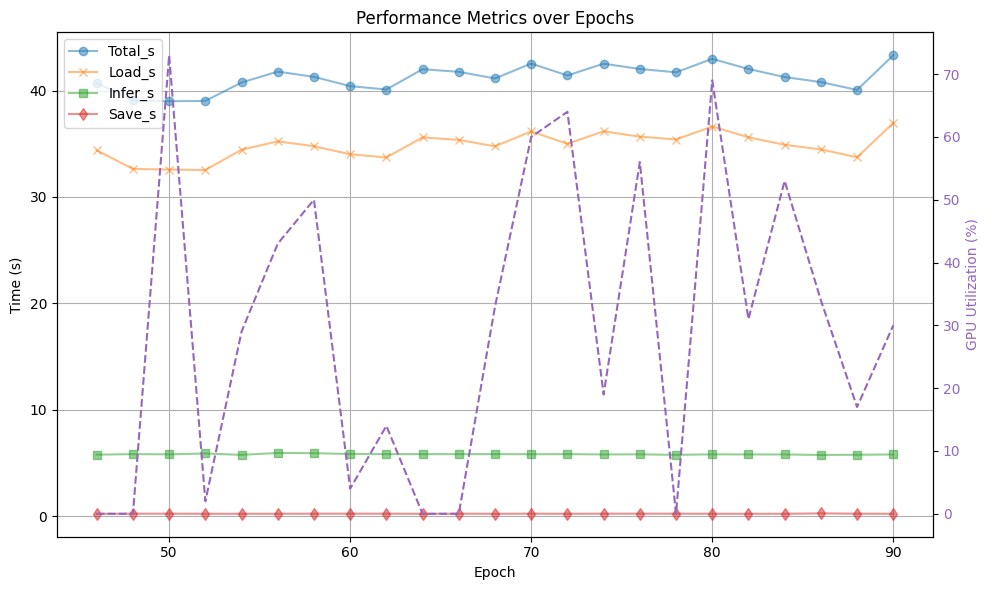

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/1.2_performance_log_2022_12_22T00_nsteps20.csv'
df = pd.read_csv(file_path)

df['GPU_Util'] = df['GPU_Util'].str.rstrip('%').astype(float)
df_filtered = df[df['Epoch'] >= 45].copy()

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Time (s)')
ax1.plot(df_filtered['Epoch'], df_filtered['Total_s'], label='Total_s', marker='o', alpha=0.5)
ax1.plot(df_filtered['Epoch'], df_filtered['Load_s'], label='Load_s', marker='x', alpha=0.5)
ax1.plot(df_filtered['Epoch'], df_filtered['Infer_s'], label='Infer_s', marker='s', alpha=0.5)
ax1.plot(df_filtered['Epoch'], df_filtered['Save_s'], label='Save_s', marker='d', alpha=0.5)
ax1.legend(loc='upper left')
ax1.grid(True)
ax2 = ax1.twinx()
ax2.set_ylabel('GPU Utilization (%)', color='tab:purple')
ax2.plot(df_filtered['Epoch'], df_filtered['GPU_Util'], color='tab:purple', linestyle='--', label='GPU_Util')
ax2.tick_params(axis='y', labelcolor='tab:purple')

plt.title('Performance Metrics over Epochs')
plt.tight_layout()
plt.savefig('1.2_performance_metrics.png')
# plt.show()

# Code with GPU utilization and timing monitoring, creation of init file

In [7]:
if not os.path.exists(data_create_fp):
    create_initialization_file(init_timestep=start_datetime, init_fp=data_create_fp)

# make this xarray into a dataarray file for earth2studio
initial_data = data.DataArrayFile(data_create_fp)

fine_tuning_start_epoch = 71 

time_1 = time.time()
print(f"Data loaded in {time_1 - time_start:.2f} seconds")

for n_epoch in epochs_to_run: 
    time_2 = time.time()
    
    # --- MONITORING START: Reset peak memory tracker for this epoch ---
    torch.cuda.reset_peak_memory_stats()
    # ----------------------------------------------------------------

    if ema:
        results_out_fp = results_out_dir+f"EMA_Checkpoint{n_epoch}_{inference_name}.nc"
    else:
        results_out_fp =  results_out_dir+"Checkpoint"+str(n_epoch)+"_"+inference_name+'.nc' 
    
    # Check if the results file already exists
    if os.path.exists(results_out_fp):
        print(f"Results file {results_out_fp} already exists. Skipping to next epoch.")
        continue 
    else:
        os.makedirs(os.path.dirname(results_out_fp), exist_ok=True)

        load_dotenv()

        if n_epoch < fine_tuning_start_epoch: 
            src_dir = "/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/"
            checkpoint_name = 'ckpt_mp0_epoch'+str(n_epoch)+'.tar'
        else:
            src_dir = "/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/multistep_sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999-multistep2/"
            n_epoch_multistep2 = n_epoch - (fine_tuning_start_epoch - 1) 
            checkpoint_name = 'ckpt_mp0_epoch'+str(n_epoch_multistep2)+'.tar'

        print(f"Loading checkpoint {checkpoint_name}")
        model_package = Package(src_dir, cache = False)
        model = SFNO.load_model(model_package, 
        checkpoint_name = checkpoint_name, EMA = ema
        )

        io = ZarrBackend()
        
        with torch.no_grad():
            io = deterministic([start_datetime], n_steps, model, initial_data, io, 
            variables_list=variables_to_select
            )

        # --- MONITORING: Capture GPU stats immediately after inference ---
        peak_mem = torch.cuda.max_memory_allocated() / 1e9 # Convert to GB
        try:
            # Quick snapshot of GPU utilization via nvidia-smi
            gpu_stats = subprocess.check_output(
                ["nvidia-smi", "--query-gpu=utilization.gpu", "--format=csv,noheader,nounits"], 
                encoding='utf-8'
            ).strip()
            gpu_util = f"{gpu_stats}%"
        except:
            gpu_util = "N/A"
        # ---------------------------------------------------------------

        # save results to netcdf
        ds = xr.open_zarr(io.root.store)
        
        ds["time"] = ds["time"].astype("datetime64[ns]")

        base_time = ds["time"].values  
        lead_timedelta = ds["lead_time"].values.astype("timedelta64[ns]")  
        valid_timesteps = (base_time[:, None] + lead_timedelta[None, :]).flatten() 
        ds = ds.drop_vars("lead_time")

        initial_time = str(ds["time"].values[0]) 
        ds = ds.isel(time=0).drop_vars("time")
        ds.attrs["initial_time"] = initial_time

        ds = ds.rename({"lead_time": "valid_time"})
        ds = ds.assign_coords(valid_time=(("valid_time",), valid_timesteps))

        lead_times_to_save = np.arange(1,9,2) # in days
        lead_times_to_save = lead_times_to_save[lead_times_to_save <= n_steps//4] 

        start_dt = datetime.fromisoformat(start_datetime)
        target_timestamps = []
        for d in lead_times_to_save:
            ts = start_dt + timedelta(days=int(d))
            target_timestamps.append(np.datetime64(ts))

        available_times = ds["valid_time"].values
        times_to_save = [t for t in target_timestamps if t in available_times] 

        if len(times_to_save) > 0:
            ds_subset = ds.sel(valid_time=times_to_save)
            ds_subset = ds_subset[variables_to_select]
            ds_subset.to_netcdf(results_out_fp, mode="w", format="NETCDF4")
            print(f"Results saved to {results_out_fp} with leadtimes {lead_times_to_save}.")
        else:
            print(f"ERROR: None of the target odd days were found. available_times: {available_times}")

        # Cleanup
        torch.cuda.empty_cache()
        del model_package
        del model
        del io
        del ds
        gc.collect()
        
        # --- MONITORING: Final timing prints ---
        time_3 = time.time()
        epoch_dur = time_3 - time_2
        total_elapsed = time_3 - time_start
        print(f"Epoch {n_epoch} Stats:")
        print(f"  Epoch Duration: {epoch_dur:.2f}s | Total Elapsed: {total_elapsed/60:.2f} min")
        print(f"  Peak VRAM: {peak_mem:.2f} GB | GPU Util Snapshot: {gpu_util}")
        print("-" * 50)
        # ---------------------------------------

Data already preprocessed: /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/init_files/Initialize_2022_12_22T00_nsteps20.nc
Data loaded in 464.76 seconds
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch1.tar
2026-01-05 14:46:16.397 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 14:46:16.397 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 14:46:16.688 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 14:46:16.723 | INFO     | deterministic_update:deterministic:122 - Inference starting!


Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 14:46:32.608 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint1_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 1 Stats:
  Duration: 26.27s | Total Elapsed: 8.18 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 0
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch3.tar
2026-01-05 14:47:11.388 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 14:47:11.389 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 14:47:11.710 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 14:47:11.750 | INFO     | deterministic_update:determin

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 14:47:27.692 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint3_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 3 Stats:
  Duration: 53.41s | Total Elapsed: 9.07 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 100
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch5.tar
2026-01-05 14:48:04.863 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 14:48:04.863 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 14:48:05.236 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 14:48:05.276 | INFO     | deterministic_update:determ

Running inference: 100%|██████████| 21/21 [00:16<00:00,  1.31it/s]


2026-01-05 14:48:21.284 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint5_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 5 Stats:
  Duration: 53.62s | Total Elapsed: 9.97 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 0
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch7.tar
2026-01-05 14:49:00.508 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 14:49:00.508 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 14:49:00.943 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 14:49:00.984 | INFO     | deterministic_update:determin

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.31it/s]


2026-01-05 14:49:16.969 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint7_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 7 Stats:
  Duration: 55.65s | Total Elapsed: 10.90 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 0
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch9.tar
2026-01-05 14:49:54.315 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 14:49:54.315 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 14:49:54.717 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 14:49:54.757 | INFO     | deterministic_update:determi

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 14:50:10.680 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint9_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 9 Stats:
  Duration: 53.72s | Total Elapsed: 11.79 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 68
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch11.tar
2026-01-05 14:50:49.906 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 14:50:49.907 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 14:50:50.339 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 14:50:50.380 | INFO     | deterministic_update:deter

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 14:51:06.286 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint11_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 11 Stats:
  Duration: 55.67s | Total Elapsed: 12.72 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 0
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch13.tar
2026-01-05 14:51:44.716 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 14:51:44.716 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 14:51:45.097 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 14:51:45.137 | INFO     | deterministic_update:dete

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 14:52:01.085 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint13_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 13 Stats:
  Duration: 54.69s | Total Elapsed: 13.63 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 0
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch15.tar
2026-01-05 14:52:37.758 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 14:52:37.759 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 14:52:38.133 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 14:52:38.174 | INFO     | deterministic_update:dete

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 14:52:54.093 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint15_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 15 Stats:
  Duration: 53.08s | Total Elapsed: 14.51 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 0
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch17.tar
2026-01-05 14:53:30.926 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 14:53:30.926 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 14:53:31.302 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 14:53:31.342 | INFO     | deterministic_update:dete

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 14:53:47.257 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint17_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 17 Stats:
  Duration: 53.08s | Total Elapsed: 15.40 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 0
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch19.tar
2026-01-05 14:54:26.028 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 14:54:26.028 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 14:54:26.402 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 14:54:26.436 | INFO     | deterministic_update:dete

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 14:54:42.308 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint19_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 19 Stats:
  Duration: 55.13s | Total Elapsed: 16.32 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 0
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch21.tar
2026-01-05 14:55:20.088 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 14:55:20.088 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 14:55:20.455 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 14:55:20.495 | INFO     | deterministic_update:dete

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 14:55:36.435 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint21_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 21 Stats:
  Duration: 54.04s | Total Elapsed: 17.22 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 0
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch23.tar
2026-01-05 14:56:13.300 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 14:56:13.300 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 14:56:13.668 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 14:56:13.709 | INFO     | deterministic_update:dete

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 14:56:29.646 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint23_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 23 Stats:
  Duration: 53.29s | Total Elapsed: 18.11 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 0
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch25.tar
2026-01-05 14:57:09.361 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 14:57:09.361 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 14:57:09.735 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 14:57:09.776 | INFO     | deterministic_update:dete

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 14:57:25.674 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint25_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 25 Stats:
  Duration: 55.94s | Total Elapsed: 19.04 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 0
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch27.tar
2026-01-05 14:58:02.331 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 14:58:02.332 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 14:58:02.712 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 14:58:02.745 | INFO     | deterministic_update:dete

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 14:58:18.656 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint27_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 27 Stats:
  Duration: 53.07s | Total Elapsed: 19.92 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 100
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch29.tar
2026-01-05 14:58:57.047 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 14:58:57.047 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 14:58:57.439 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 14:58:57.479 | INFO     | deterministic_update:de

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 14:59:13.385 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint29_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 29 Stats:
  Duration: 54.66s | Total Elapsed: 20.83 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 100
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch31.tar
2026-01-05 14:59:52.021 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 14:59:52.021 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 14:59:52.406 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 14:59:52.447 | INFO     | deterministic_update:de

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 15:00:08.375 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint31_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 31 Stats:
  Duration: 55.06s | Total Elapsed: 21.75 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 0
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch33.tar
2026-01-05 15:00:46.029 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:00:46.029 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:00:46.402 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:00:46.443 | INFO     | deterministic_update:dete

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 15:01:02.398 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint33_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 33 Stats:
  Duration: 54.01s | Total Elapsed: 22.65 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 0
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch35.tar
2026-01-05 15:01:39.036 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:01:39.036 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:01:39.407 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:01:39.447 | INFO     | deterministic_update:dete

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.31it/s]


2026-01-05 15:01:55.444 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint35_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 35 Stats:
  Duration: 52.99s | Total Elapsed: 23.54 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 100
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch37.tar
2026-01-05 15:02:34.534 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:02:34.534 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:02:34.910 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:02:34.951 | INFO     | deterministic_update:de

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 15:02:50.902 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint37_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 37 Stats:
  Duration: 55.52s | Total Elapsed: 24.46 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 0
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch39.tar
2026-01-05 15:03:28.694 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:03:28.694 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:03:29.069 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:03:29.110 | INFO     | deterministic_update:dete

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 15:03:45.052 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint39_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 39 Stats:
  Duration: 54.10s | Total Elapsed: 25.36 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 98
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch41.tar
2026-01-05 15:04:21.225 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:04:21.226 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:04:21.606 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:04:21.644 | INFO     | deterministic_update:det

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 15:04:37.545 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint41_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 41 Stats:
  Duration: 52.54s | Total Elapsed: 26.24 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 100
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch43.tar
2026-01-05 15:05:14.623 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:05:14.624 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:05:15.003 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:05:15.043 | INFO     | deterministic_update:de

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 15:05:30.964 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint43_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 43 Stats:
  Duration: 53.36s | Total Elapsed: 27.13 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 0
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch45.tar
2026-01-05 15:06:07.735 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:06:07.735 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:06:08.119 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:06:08.160 | INFO     | deterministic_update:dete

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 15:06:24.090 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint45_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 45 Stats:
  Duration: 53.22s | Total Elapsed: 28.01 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 99
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch47.tar
2026-01-05 15:07:01.978 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:07:01.979 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:07:02.370 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:07:02.410 | INFO     | deterministic_update:det

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 15:07:18.358 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint47_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 47 Stats:
  Duration: 54.16s | Total Elapsed: 28.92 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 0
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch49.tar
2026-01-05 15:07:55.257 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:07:55.257 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:07:55.655 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:07:55.696 | INFO     | deterministic_update:dete

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.31it/s]


2026-01-05 15:08:11.670 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint49_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 49 Stats:
  Duration: 53.39s | Total Elapsed: 29.81 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 0
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch51.tar
2026-01-05 15:08:48.214 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:08:48.214 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:08:48.602 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:08:48.644 | INFO     | deterministic_update:dete

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 15:09:04.587 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint51_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 51 Stats:
  Duration: 52.93s | Total Elapsed: 30.69 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 100
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch53.tar
2026-01-05 15:09:41.490 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:09:41.490 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:09:41.885 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:09:41.926 | INFO     | deterministic_update:de

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 15:09:57.859 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint53_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 53 Stats:
  Duration: 53.24s | Total Elapsed: 31.58 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 99
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch55.tar
2026-01-05 15:10:38.391 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:10:38.391 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:10:38.781 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:10:38.823 | INFO     | deterministic_update:det

Running inference: 100%|██████████| 21/21 [00:16<00:00,  1.31it/s]


2026-01-05 15:10:54.837 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint55_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 55 Stats:
  Duration: 57.00s | Total Elapsed: 32.53 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 0
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch57.tar
2026-01-05 15:11:31.628 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:11:31.628 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:11:32.018 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:11:32.054 | INFO     | deterministic_update:dete

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 15:11:47.951 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint57_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 57 Stats:
  Duration: 53.04s | Total Elapsed: 33.41 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 0
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch59.tar
2026-01-05 15:12:26.879 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:12:26.879 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:12:27.257 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:12:27.297 | INFO     | deterministic_update:dete

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 15:12:43.241 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint59_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 59 Stats:
  Duration: 55.37s | Total Elapsed: 34.33 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 98
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch61.tar
2026-01-05 15:13:18.905 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:13:18.905 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:13:19.201 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:13:19.241 | INFO     | deterministic_update:det

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 15:13:35.182 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint61_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 61 Stats:
  Duration: 51.87s | Total Elapsed: 35.20 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 100
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch63.tar
2026-01-05 15:14:11.698 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:14:11.699 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:14:11.997 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:14:12.038 | INFO     | deterministic_update:de

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 15:14:27.982 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint63_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 63 Stats:
  Duration: 52.87s | Total Elapsed: 36.08 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 94
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch65.tar
2026-01-05 15:15:05.212 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:15:05.213 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:15:05.494 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:15:05.534 | INFO     | deterministic_update:det

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 15:15:21.485 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint65_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 65 Stats:
  Duration: 53.43s | Total Elapsed: 36.97 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 0
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch67.tar
2026-01-05 15:15:58.445 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:15:58.445 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:15:58.734 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:15:58.775 | INFO     | deterministic_update:dete

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 15:16:14.714 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint67_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 67 Stats:
  Duration: 53.30s | Total Elapsed: 37.86 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 0
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch69.tar
2026-01-05 15:16:50.569 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:16:50.569 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:16:50.864 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:16:50.904 | INFO     | deterministic_update:dete

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 15:17:06.842 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint69_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 69 Stats:
  Duration: 52.06s | Total Elapsed: 38.73 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 0
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/multistep_sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999-multistep2/ with checkpoint ckpt_mp0_epoch1.tar
2026-01-05 15:17:45.227 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:17:45.228 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:17:45.543 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:17:45.585 | INFO     | deter

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 15:18:01.514 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint71_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 71 Stats:
  Duration: 54.74s | Total Elapsed: 39.64 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 0
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/multistep_sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999-multistep2/ with checkpoint ckpt_mp0_epoch3.tar
2026-01-05 15:18:40.345 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:18:40.346 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:18:40.669 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:18:40.710 | INFO     | deter

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 15:18:56.665 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint73_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 73 Stats:
  Duration: 55.21s | Total Elapsed: 40.56 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 83
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/multistep_sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999-multistep2/ with checkpoint ckpt_mp0_epoch5.tar
2026-01-05 15:19:23.406 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:19:23.406 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:19:23.759 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:19:23.800 | INFO     | dete

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 15:19:39.765 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint75_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 75 Stats:
  Duration: 43.12s | Total Elapsed: 41.28 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 0
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/multistep_sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999-multistep2/ with checkpoint ckpt_mp0_epoch7.tar
2026-01-05 15:20:00.413 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:20:00.414 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:20:00.776 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:20:00.816 | INFO     | deter

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 15:20:16.764 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint77_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 77 Stats:
  Duration: 36.93s | Total Elapsed: 41.89 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 100
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/multistep_sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999-multistep2/ with checkpoint ckpt_mp0_epoch9.tar
2026-01-05 15:20:40.723 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:20:40.723 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:20:41.086 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:20:41.127 | INFO     | det

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 15:20:57.072 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint79_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 79 Stats:
  Duration: 40.35s | Total Elapsed: 42.56 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 83
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/multistep_sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999-multistep2/ with checkpoint ckpt_mp0_epoch11.tar
2026-01-05 15:21:16.373 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:21:16.373 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:21:16.763 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:21:16.804 | INFO     | det

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 15:21:32.722 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint81_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 81 Stats:
  Duration: 35.61s | Total Elapsed: 43.16 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 98
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/multistep_sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999-multistep2/ with checkpoint ckpt_mp0_epoch13.tar
2026-01-05 15:22:00.469 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:22:00.469 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:22:00.834 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:22:00.875 | INFO     | det

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 15:22:16.808 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint83_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 83 Stats:
  Duration: 44.10s | Total Elapsed: 43.89 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 99
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/multistep_sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999-multistep2/ with checkpoint ckpt_mp0_epoch15.tar
2026-01-05 15:22:37.168 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:22:37.168 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:22:37.553 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:22:37.593 | INFO     | det

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 15:22:53.549 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint85_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 85 Stats:
  Duration: 36.71s | Total Elapsed: 44.51 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 0
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/multistep_sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999-multistep2/ with checkpoint ckpt_mp0_epoch17.tar
2026-01-05 15:23:12.874 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:23:12.874 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:23:13.293 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:23:13.333 | INFO     | dete

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 15:23:29.280 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint87_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 87 Stats:
  Duration: 35.74s | Total Elapsed: 45.10 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 0
0
0
0
0
0
0
0%
--------------------------------------------------
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/multistep_sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999-multistep2/ with checkpoint ckpt_mp0_epoch19.tar
2026-01-05 15:23:49.317 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 15:23:49.317 | INFO     | deterministic_update:deterministic:68 - Inference device: cuda
2026-01-05 15:23:49.760 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 15:23:49.800 | INFO     | dete

Running inference: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


2026-01-05 15:24:05.745 | SUCCESS  | deterministic_update:deterministic:146 - Inference complete
Results saved to /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/2022_12_27/Checkpoint89_2022_12_22T00_nsteps20.nc with 3 timesteps.
Epoch 89 Stats:
  Duration: 36.45s | Total Elapsed: 45.71 min
  Peak VRAM: 16.25 GB | GPU Util Snapshot: 100
0
0
0
0
0
0
0%
--------------------------------------------------


In [ ]:
if os.path.exists(data_create_fp):
    print(f"Data already preprocessed: {data_create_fp}")
else:
    sys.exit(f"Data not found use Create_Initial_Data.ipynb to create: {data_create_fp}")

# make this xarray into a dataarray file for earth2studio
initial_data = data.DataArrayFile(data_create_fp)

fine_tuning_start_epoch = 71 # the epoch where fine-tuning starts (important for correctly accessing the checkpoints)

time_1 = time.time()
print(f"Data loaded in {time_1 - time_start:.2f} seconds")

for n_epoch in epochs_to_run: 
    time_2 = time.time()

    if ema:
        results_out_fp = results_out_dir+f"EMA_Checkpoint{n_epoch}_{inference_name}.nc"
    else:
        results_out_fp =  results_out_dir+"Checkpoint"+str(n_epoch)+"_"+inference_name+'.nc' 
    
    # Check if the results file already exists
    if os.path.exists(results_out_fp):
        print(f"Results file {results_out_fp} already exists. Skipping to next epoch.")
        continue  # Skip the rest of the loop and go to the next iteration
    else:
        os.makedirs(os.path.dirname(results_out_fp), exist_ok=True)

        load_dotenv()

        if n_epoch < fine_tuning_start_epoch: # pre-fine-tuning phase epochs are numbered 1-70
            src_dir = "/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/"
            checkpoint_name = 'ckpt_mp0_epoch'+str(n_epoch)+'.tar'
        else:
            src_dir = "/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/multistep_sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999-multistep2/"
            n_epoch_multistep2 = n_epoch - (fine_tuning_start_epoch - 1) # fine-tuning phase epochs are numbered from 1-20
            checkpoint_name = 'ckpt_mp0_epoch'+str(n_epoch_multistep2)+'.tar'

        print(f"Loading model from {os.path.tail(src_dir)} with checkpoint {checkpoint_name}")
        # Load the model package from storage
        model_package = Package(src_dir, cache = False)
        model = SFNO.load_model(model_package, 
        checkpoint_name = checkpoint_name, EMA = ema
        )

        # Create the IO handler, store in memory
        io = ZarrBackend()
        
        with torch.no_grad():
            # run inference
            io = deterministic([start_datetime], n_steps, model, initial_data, io, 
            variables_list=variables_to_select
            )

        print(io.root.tree())

        # save results to netcdf
        # Open the Zarr group from the in-memory store using xarray
        ds = xr.open_zarr(io.root.store)
        
        # SANITY CHECKING...
        print("Dataset times:", ds["time"].values)
        print("Dataset dimensions:", {dim: ds.dims[dim] for dim in ds.dims})
        print("Lead times", ds["lead_time"].values)

        # Convert the 'time' coordinate in ds to datetime64 format
        ds["time"] = ds["time"].astype("datetime64[ns]")

        # Convert lead_time from nanoseconds to timedelta64[ns]
        base_time = ds["time"].values  # shape (n_time,)
        lead_timedelta = ds["lead_time"].values.astype("timedelta64[ns]")  # shape (n_lead_time,)
        # Broadcast to 2D: (time, lead_time)
        valid_timesteps = (base_time[:, None] + lead_timedelta[None, :]).flatten() 
        # Drop the old lead_time coordinate
        ds = ds.drop_vars("lead_time")

        # Assume ds has dimensions (time, lead_time, lat, lon) and only one time
        initial_time = str(ds["time"].values[0])  # Save the initial time as a string
        # Remove the time dimension by selecting the first (and only) time
        ds = ds.isel(time=0).drop_vars("time")
        # Add the initial time as a global attribute
        ds.attrs["initial_time"] = initial_time

        # Create valid_time by adding lead_timedelta to base_time
        ds = ds.rename({"lead_time": "valid_time"})
        # Assign valid_time as a coordinate
        ds = ds.assign_coords(valid_time=(("valid_time",), valid_timesteps))

        lead_times_to_save = np.arange(1,9,2) # in days
        lead_times_to_save = lead_times_to_save[lead_times_to_save <= n_steps//4] # only keep lead times that are within the n_steps range

        # Calculate the specific timestamps for these days
        start_dt = datetime.fromisoformat(start_datetime)
        target_timestamps = []
        for d in lead_times_to_save:
            ts = start_dt + timedelta(days=d)
            target_timestamps.append(np.datetime64(ts))

        print(f"Attempting to save forecasts for days: {lead_times_to_save}")

        available_times = ds["valid_time"].values
        times_to_save = [t for t in target_timestamps if t in available_times] # overlap between target lead times and available times

        if len(times_to_save) > 0:
            ds_subset = ds.sel(valid_time=times_to_save)
            ds_subset = ds_subset[variables_to_select]
            ds_subset.to_netcdf(results_out_fp, mode="w", format="NETCDF4")
            print(f"Results saved to {results_out_fp} with {len(times_to_save)} timesteps.")
        else:
            print(f"ERROR: None of the target odd days were found in the output. available_times: {available_times}")

        # # only save the final time step
        # if np.datetime64(final_datetime) in ds["valid_time"].values:
        #     ds = ds.sel(valid_time=[final_datetime])
        #     ds = ds[variables_to_select]
        #     ds.to_netcdf(results_out_fp, mode="w", format="NETCDF4")
        #     print(f"Results saved to {results_out_fp}")
        # else:
        #     print(f"ERROR: final_datetime {final_datetime} not found in ds['valid_time']. No file saved.")

        #some cleanup
        torch.cuda.empty_cache()
        del model_package
        del model
        del io
        del ds
        gc.collect()
        time_3 = time.time()
        print(f"Epoch {n_epoch} done: {time_3 - time_2:.2f} seconds")


Data already preprocessed: /projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment1/init_files/Initialize_2022_12_22T00_nsteps20.nc
Data loaded in 5.40 seconds
Loading model from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/ with checkpoint ckpt_mp0_epoch1.tar
2026-01-05 14:27:21.286 | INFO     | deterministic_update:deterministic:61 - Running simple workflow!
2026-01-05 14:27:21.314 | INFO     | deterministic_update:deterministic:68 - Inference device: cpu
2026-01-05 14:27:22.057 | SUCCESS  | deterministic_update:deterministic:92 - Fetched data from DataArrayFile
2026-01-05 14:27:22.300 | INFO     | deterministic_update:deterministic:122 - Inference starting!


In [3]:
# Compare the output of my forecast to Becca's saved forecast
my_forecast ='/projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment0/2022_09_29/Checkpoint70_2022_09_24T00_nsteps20.nc' 
beccas_forecast = '/projectnb/eb-general/wade/sfno/inference_runs/Ian/leadtime_fivedays/Checkpoint70_2022_09_24T00_nsteps20.nc'
my_ds = xr.open_dataset(my_forecast)
beccas_ds = xr.open_dataset(beccas_forecast)
print(my_ds)
print(beccas_ds)

<xarray.Dataset> Size: 12MB
Dimensions:     (valid_time: 1, lat: 721, lon: 1440)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 8B 2022-09-29
  * lat         (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon         (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Data variables:
    msl         (valid_time, lat, lon) float32 4MB ...
    u10m        (valid_time, lat, lon) float32 4MB ...
    v10m        (valid_time, lat, lon) float32 4MB ...
Attributes:
    initial_time:  2022-09-24T00:00:00.000000000
<xarray.Dataset> Size: 12MB
Dimensions:     (valid_time: 1, lat: 721, lon: 1440)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 8B 2022-09-29
  * lat         (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon         (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Data variables:
    msl         (valid_time, lat, lon) float32 4MB ...
    u10m        (valid_time, lat, lon) float32 4MB ...
    v10m

To check what epoch a checkpoint is (e.g. if epoch number is not in the filepath):

In [38]:
import torch
import os

dir='/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/training_checkpoints/' # step 1 of training (epochs 1-70)
dir2='/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/multistep_sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999-multistep2/training_checkpoints/' # step 2 of training (epochs 71-90

# List of files to check
files_to_check = [dir + "best_ckpt_mp0.tar", 
                  dir + "ckpt_mp0.tar",
                  dir2 +  "best_ckpt_mp0.tar",
                    dir2 + "ckpt_mp0.tar"
                    ]
                
for filename in files_to_check:
    # Load the checkpoint
    # map_location='cpu' allows you to inspect this even without a GPU
    # weights_only=False allows loading the full dictionary structure
    checkpoint = torch.load(filename, map_location='cpu', weights_only=False)
    epoch = checkpoint.get('epoch', 'N/A')
    
    print(f"{filename:<25}")
    print(f'epoch: {str(epoch)}')
    print()

/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/training_checkpoints/best_ckpt_mp0.tar
epoch: 70

/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/training_checkpoints/ckpt_mp0.tar
epoch: 70

/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/multistep_sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999-multistep2/training_checkpoints/best_ckpt_mp0.tar
epoch: 19

/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/multistep_sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999-multistep2/training_checkpoints/ckpt_mp0.tar
epoch: 20



the above output shows that the best_ckpt is the best ckpt *for each phase*, and ckpt_mp0 is the *final* ckpt for that phase
- checkpoint numbering resets for each phase so phase 2 is numbered 1-20


# Original script:

In [ ]:
import os
import subprocess
from dotenv import load_dotenv

from earth2studio.io import ZarrBackend
from SFNO_update import SFNO
import earth2studio.data as data
from earth2studio.models.auto import Package
from utils import filename_to_year, datetime_range, open_hdf5
from deterministic_update import deterministic

from datetime import datetime, timedelta
import json
import xarray as xr
from typing import List
import shutil
import sys
import gc
import numpy as np
import time

import torch

# Check if CUDA (GPU support) is available
is_available = torch.cuda.is_available()
print(f"Is CUDA available? {is_available}")

if is_available:
    # Get the number of available GPUs
    gpu_count = torch.cuda.device_count()
    print(f"Number of GPUs available: {gpu_count}")

    # Get the ID of the current GPU
    current_gpu = torch.cuda.current_device()
    print(f"Current GPU ID: {current_gpu}")

    # Get the name of the current GPU
    gpu_name = torch.cuda.get_device_name(current_gpu)
    print(f"Current GPU Name: {gpu_name}")

    print(f"Memory (VRAM):      {torch.cuda.get_device_properties(current_gpu).total_memory / 1e9:.2f} GB")
else:
    print("CUDA is not available. Running on CPU.")

time_start = time.time()

############# Double check these before running the script #############
#select start datetime and n_steps, each n_step = 6hrs
start_datetime = "2021-09-20T00:00:00" # "2021_09_20T00:00:00"
variables_to_select = ['tcwv'] #Only save selected variables - it slows down inference SIGNIFICANTLY to save all 74 variables
experiment_number = 0
n_steps = 20  #number of 6hr steps to forecast

boring = False
ema = False

# Create the inference name based on the start datetime and number of steps
inference_name = datetime.fromisoformat(start_datetime).strftime("%Y_%m_%dT%H")+'_nsteps'+str(n_steps)
data_create_fp = "/projectnb/eb-general/wade/sfno/inference_runs/Ian/Initialize_data/Initialize_"+inference_name+".nc"

# Calculate the final datetime based from the start datetime and number of steps
final_datetime = (datetime.fromisoformat(start_datetime) + timedelta(hours = int(n_steps*6))).isoformat() 

# Directories
results_out_dir = f"/projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment{str(experiment_number)}/{final_datetime[:10].replace('-', '_')}/"

############# Double check these before running the script #############


if os.path.exists(data_create_fp):
    print(f"Data already preprocessed: {data_create_fp}")
else:
    sys.exit(f"Data not found use Create_Initial_Data.ipynb to create: {data_create_fp}")

#make this xarray into a dataarray file for earth2studio
initial_data = data.DataArrayFile(data_create_fp)

time_1 = time.time()
print(f"Data loaded in {time_1 - time_start:.2f} seconds")


for n_epoch in np.arange(1,3): #70,1):
    time_2 = time.time()
    # if boring:
    #     # Create the final datetime string in the desired format
    #     
    # else:# Create the final datetime string in the desired format

    if ema:
        results_out_fp = results_out_dir+f"EMA_Checkpoint{n_epoch}_{inference_name}.nc"
    else:
        results_out_fp = results_out_fp = results_out_dir+"/Checkpoint"+str(n_epoch)+"_"+inference_name+'.nc' 
    
    # Check if the results file already exists
    if os.path.exists(results_out_fp):
        print(f"Results file {results_out_fp} already exists. Skipping to next epoch.")
        continue  # Skip the rest of the loop and go to the next iteration
    else:
        os.makedirs(os.path.dirname(results_out_fp), exist_ok=True)

        load_dotenv()  

        # Make temporary folder with all the metadata in it.
        src_dir = "/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/"
        # Load the model package from storage
        model_package = Package(src_dir, cache = False)
        model = SFNO.load_model(model_package, checkpoint_name = 'ckpt_mp0_epoch'+str(n_epoch)+'.tar', EMA = ema)

        # Create the IO handler, store in memory
        io = ZarrBackend()
        
        with torch.no_grad():
            # run inference
            io = deterministic([start_datetime], n_steps, model, initial_data, io, variables_list=variables_to_select)

        print(io.root.tree())


        # save results to netcdf
        # Open the Zarr group from the in-memory store using xarray
        ds = xr.open_zarr(io.root.store)

        # Convert the 'time' coordinate in ds to datetime64 format
        ds["time"] = ds["time"].astype("datetime64[ns]")

        # Convert lead_time from nanoseconds to timedelta64[ns]
        base_time = ds["time"].values  # shape (n_time,)
        lead_timedelta = ds["lead_time"].values.astype("timedelta64[ns]")  # shape (n_lead_time,)
        # Broadcast to 2D: (time, lead_time)
        valid_timesteps = (base_time[:, None] + lead_timedelta[None, :]).flatten() 
        # Drop the old lead_time coordinate
        ds = ds.drop_vars("lead_time")

        # Assume ds has dimensions (time, lead_time, lat, lon) and only one time
        initial_time = str(ds["time"].values[0])  # Save the initial time as a string
        # Remove the time dimension by selecting the first (and only) time
        ds = ds.isel(time=0).drop_vars("time")
        # Add the initial time as a global attribute
        ds.attrs["initial_time"] = initial_time

        # Create valid_time by adding lead_timedelta to base_time
        ds = ds.rename({"lead_time": "valid_time"})
        # Assign valid_time as a coordinate
        ds = ds.assign_coords(valid_time=(("valid_time",), valid_timesteps))

        # only save the final time step
        if np.datetime64(final_datetime) in ds["valid_time"].values:
            ds = ds.sel(valid_time=[final_datetime])
            ds = ds[variables_to_select]
            ds.to_netcdf(results_out_fp, mode="w", format="NETCDF4")
            print(f"Results saved to {results_out_fp}")
        else:
            print(f"ERROR: final_datetime {final_datetime} not found in ds['valid_time']. No file saved.")


        #some cleanup
        torch.cuda.empty_cache()
        del model_package
        del model
        del io
        del ds
        gc.collect()
        time_3 = time.time()
        print(f"Epoch {n_epoch} done: {time_3 - time_2:.2f} seconds")



#     for n_epoch in np.arange(36,71,1):
#         time_2 = time.time()
#         if boring:
#             # Create the final datetime string in the desired format
#             results_out_fp = "/barnes-engr-scratch2/C837824079/Experiment"+str(experiment_number)+"/Forecasts_Boring/"+final_datetime[:10].replace("-", "_")+"/Checkpoint"+str(n_epoch)+"_"+inference_name+'.nc'
#         else:# Create the final datetime string in the desired format
#             if ema:
#                 results_out_fp = f"/barnes-engr-scratch2/C837824079/Experiment{str(experiment_number)}/Forecast/EMA_9/Checkpoint{n_epoch}_{inference_name}.nc"         
#             else:
#                 results_out_fp = "/projectnb/eb-general/rbaiman/SFNO/Example_Inference/Example_Forecast/Checkpoint"+str(n_epoch)+"_"+inference_name+'.nc'

#         # Check if the results file already exists
#         if os.path.exists(results_out_fp):
#             print(f"Results file {results_out_fp} already exists. Skipping to next epoch.")
#             continue  # Skip the rest of the loop and go to the next iteration
#         else:
#             os.makedirs(os.path.dirname(results_out_fp), exist_ok=True)

#             load_dotenv()  

#             # Make temporary folder with all the metadata in it.
#             src_dir = "/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/"

#             # Load the model package from storage
#             model_package = Package(src_dir, cache = False)
#             model = SFNO.load_model(model_package, checkpoint_name = 'ckpt_mp0_epoch'+str(n_epoch)+'.tar', EMA = ema)

#             # Create the IO handler, store in memory
#             io = ZarrBackend()
            
#             with torch.no_grad():
#                 # run inference
#                 io = deterministic([start_datetime], n_steps, model, initial_data, io, variables_list=variables_to_select)

#             print(io.root.tree())


#             # save results to netcdf
#             # Open the Zarr group from the in-memory store using xarray
#             ds = xr.open_zarr(io.root.store)

#             # Convert the 'time' coordinate in ds to datetime64 format
#             ds["time"] = ds["time"].astype("datetime64[ns]")

#             # Convert lead_time from nanoseconds to timedelta64[ns]
#             base_time = ds["time"].values  # shape (n_time,)
#             lead_timedelta = ds["lead_time"].values.astype("timedelta64[ns]")  # shape (n_lead_time,)
#             # Broadcast to 2D: (time, lead_time)
#             valid_timesteps = (base_time[:, None] + lead_timedelta[None, :]).flatten() 
#             # Drop the old lead_time coordinate
#             ds = ds.drop_vars("lead_time")

#             # Assume ds has dimensions (time, lead_time, lat, lon) and only one time
#             initial_time = str(ds["time"].values[0])  # Save the initial time as a string
#             # Remove the time dimension by selecting the first (and only) time
#             ds = ds.isel(time=0).drop_vars("time")
#             # Add the initial time as a global attribute
#             ds.attrs["initial_time"] = initial_time

#             # Create valid_time by adding lead_timedelta to base_time
#             ds = ds.rename({"lead_time": "valid_time"})
#             # Assign valid_time as a coordinate
#             ds = ds.assign_coords(valid_time=(("valid_time",), valid_timesteps))

#             # only save the final time step
#             if np.datetime64(final_datetime) in ds["valid_time"].values:
#                 ds = ds.sel(valid_time=[final_datetime])
#                 ds = ds[variables_to_select]
#                 ds.to_netcdf(results_out_fp, mode="w", format="NETCDF4")
#                 print(f"Results saved to {results_out_fp}")
#             else:
#                 print(f"ERROR: final_datetime {final_datetime} not found in ds['valid_time']. No file saved.")


#             #some cleanup
#             torch.cuda.empty_cache()
#             del model_package
#             del model
#             del io
#             del ds
#             gc.collect()
#             time_3 = time.time()
#             print(f"Epoch {n_epoch} done: {time_3 - time_2:.2f} seconds")


# for n_epoch in np.arange(1,21,1):
#     time_2 = time.time()
#     # Create the final datetime string in the desired format
#     if boring:
#         # Create the final datetime string in the desired format
#         results_out_fp = "/barnes-engr-scratch2/C837824079/Experiment"+str(experiment_number)+"/Forecasts_Boring/"+final_datetime[:10].replace("-", "_")+"/Checkpoint"+str(n_epoch+70)+"_"+inference_name+'.nc'
#     else:# Create the final datetime string in the desired format
#         if ema:
#             results_out_fp = f"/barnes-engr-scratch2/C837824079/Experiment{str(experiment_number)}/Forecast/EMA_9/Checkpoint{n_epoch+70}_{inference_name}.nc"
#         else:
#             results_out_fp = "/projectnb/eb-general/rbaiman/SFNO/Example_Inference/Example_Forecast/Checkpoint"+str(n_epoch+70)+"_"+inference_name+'.nc'

    
#     # Check if the results file already exists
#     if os.path.exists(results_out_fp):
#         print(f"Results file {results_out_fp} already exists. Skipping to next epoch.")
#         continue  # Skip the rest of the loop and go to the next iteration
#     else:
#         os.makedirs(os.path.dirname(results_out_fp), exist_ok=True)

#         load_dotenv()  

#         # Make temporary folder with all the metadata in it.
#         src_dir = "/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/multistep_sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999-multistep2/"

#         # Load the model package from storage
#         model_package = Package(src_dir, cache = False)
#         model = SFNO.load_model(model_package, checkpoint_name = 'ckpt_mp0_epoch'+str(n_epoch)+'.tar', EMA = ema)

#         # Create the IO handler, store in memory
#         io = ZarrBackend()

#         print(f"Running inference for {inference_name}")
#         with torch.no_grad():
#             # run inference
#             io = deterministic([start_datetime], n_steps, model, initial_data, io, variables_list=variables_to_select)

#         # print(io.root.tree())

#         # save results to netcdf
#         # Open the Zarr group from the in-memory store using xarray
#         ds = xr.open_zarr(io.root.store)

#         # Convert the 'time' coordinate in ds to datetime64 format
#         ds["time"] = ds["time"].astype("datetime64[ns]")

#         # Convert lead_time from nanoseconds to timedelta64[ns]
#         base_time = ds["time"].values  # shape (n_time,)
#         lead_timedelta = ds["lead_time"].values.astype("timedelta64[ns]")  # shape (n_lead_time,)
#         # Broadcast to 2D: (time, lead_time)
#         valid_timesteps = (base_time[:, None] + lead_timedelta[None, :]).flatten() 
#         # Drop the old lead_time coordinate
#         ds = ds.drop_vars("lead_time")

#         # Assume ds has dimensions (time, lead_time, lat, lon) and only one time
#         initial_time = str(ds["time"].values[0])  # Save the initial time as a string
#         # Remove the time dimension by selecting the first (and only) time
#         ds = ds.isel(time=0).drop_vars("time")
#         # Add the initial time as a global attribute
#         ds.attrs["initial_time"] = initial_time

#         # Create valid_time by adding lead_timedelta to base_time
#         ds = ds.rename({"lead_time": "valid_time"})
#         # Assign valid_time as a coordinate
#         ds = ds.assign_coords(valid_time=(("valid_time",), valid_timesteps))

#         # only save the final time step
#         if np.datetime64(final_datetime) in ds["valid_time"].values:
#             ds = ds.sel(valid_time=[final_datetime])
#             ds = ds[variables_to_select]
#             ds.to_netcdf(results_out_fp, mode="w", format="NETCDF4")
#             print(f"Results saved to {results_out_fp}")
#         else:
#             print(f"ERROR: final_datetime {final_datetime} not found in ds['valid_time']. No file saved.")


#         #some cleanup
#         torch.cuda.empty_cache()
#         del model_package
#         del model
#         del io
#         del ds
#         gc.collect()
#         time_3 = time.time()
#         print(f"Epoch {n_epoch+70} done: {time_3 - time_2:.2f} seconds")

